In [2]:
import pandas as pd
import numpy as np
import xgboost
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import joblib

## Read data

In [3]:
df = pd.read_csv('SciData_STEM.csv')
pd.set_option('display.max_columns', None)

In [4]:
#df = pd.read_csv('/content/SciData_STEM (1).csv')
#pd.set_option('display.max_columns', None)

## Data profiling

This study analyses school-based data from a public article of Vuong et. al (2021) of Vietnam, covering junior high school student records from  December 2017 and January 2018 across various disciplines. The dataset comprises 4,966 records with 42 independent variables, encompassing five major categories: 1) students’ personal information (including STEM performance), 2) family-related information, 3) book reading preferences, 4) book reading frequency/
habits, and 5) classroom activities.

In [5]:
df.head()

q_FormDataId  q_63   q_83  School  Grade     Sex  APS45  APSVNEN  RankingF  \
0             4    13  43075       2    8.0  Female   7.00      0.0         3   
1             5  6225  43074       3    9.0     NaN   0.00      0.0         0   
2             6  6226  43074       3    9.0  Female   6.50      0.0         1   
3             7  6228  43074       3    9.0  Female   8.50      0.0         1   
4             8  6229  43074       3    9.0  Female   9.75      0.0         2   

   NumberofChi Readbook Topic         FutureJob_VN FutureJob_VN (translated)  \
0            4      yes     e               bác sĩ                    Doctor   
1            0      yes     d               Họa sĩ                   Painter   
2            2      yes     b              Thợ may                    Worker   
3            2      yes     d  Công nhân viên chức            Public servant   
4            3      yes     d        Vận động viên                   Athlete   

   CareerFat CareerFat (translated) CarFatGr  AgeFat   EduFat  CareerMot  \
0  làm ruộng                 Farmer    Labor    48.0  UnderHi  Công nhân   
1    Công an         Police officer    Labor     NaN      Uni  Giáo viên   
2  Làm ruộng                 Farmer    Labor     NaN       Hi  Làm ruộng   
3  Công nhân                 Worker    Labor    41.0       Hi  Công nhân   
4  Làm ruộng                 Farmer    Labor    38.0  UnderHi  Làm ruộng   

  CareerMot (translated)       CarMotGr  AgeMot   EduMot EcoStt KnowledgeInc  \
0                 Worker          Labor    40.0  UnderHi    med           no   
1                Teacher  Intellectuals     NaN      Uni   rich           no   
2                 Farmer          Labor     NaN       Hi    med           no   
3                 Worker          Labor    40.0       Hi    med           no   
4                 Farmer          Labor    36.0  UnderHi    med           no   

  EstIncome Buybook Hobby  TimeSci  TimeSoc Readstory Typebook Typebook_Other  \
0       NaN     yes     a        2      2.0        no        c            NaN   
1       NaN     yes     b        2      1.0       yes        d            NaN   
2       NaN     yes     c        2      1.0       NaN        a            NaN   
3   8000000     yes     b        1      1.0       NaN        c            NaN   
4       NaN     yes     b        1      1.0        no        a            NaN   

  Reason  Source PrioAct AftAct  \
0      a     buy       a      b   
1      a     buy       c      a   
2      a     buy       a      a   
3      a     buy       d      a   
4      a  borrow       a      b   

                                         Read_like EncourAct MostlikedAct  \
0  Thám tử lừng danh Cô nan\r\nShin Cậu bé bút chì       yes            b   
1                                              NaN       yes            d   
2                      Truyện Conan\r\nTruyện Kiều       NaN            b   
3   400 bài tập hóa học\r\nBài tập nâng cao toán 9       yes            a   
4                                              NaN       yes            d   

  Bookcase                                       Notread_like  
0        d  Lão Hạc\r\nAlibaba và 40 tên cướp\r\nCây đèn thần  
1        c                                                NaN  
2        a       Quà tặng cuộc sống\r\nTắt đèn\r\nTruyện Kiều  
3        d                                                NaN  
4        d                                                NaN

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4966 entries, 0 to 4965
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   q_FormDataId               4966 non-null   int64  
 1   q_63                       4966 non-null   object 
 2   q_83                       4863 non-null   object 
 3   School                     4966 non-null   int64  
 4   Grade                      4884 non-null   float64
 5   Sex                        4915 non-null   object 
 6   APS45                      4957 non-null   float64
 7   APSVNEN                    4966 non-null   float64
 8   RankingF                   4966 non-null   int64  
 9   NumberofChi                4966 non-null   int64  
 10  Readbook                   4776 non-null   object 
 11  Topic                      4644 non-null   object 
 12  FutureJob_VN               4887 non-null   object 
 13  FutureJob_VN (translated)  4662 non-null   objec

In [7]:
#Print the percentage of missing value in all columns
print((df.isna().sum() * 100 / len(df)).sort_values(ascending=False).head(20))

EstIncome                    90.998792
Typebook_Other               86.387435
AgeMot                        9.484495
AgeFat                        9.403947
EduFat                        9.021345
Notread_like                  7.450665
EduMot                        7.188884
MostlikedAct                  6.886830
Topic                         6.484092
KnowledgeInc                  6.363270
FutureJob_VN (translated)     6.121627
Readstory                     5.879984
Readbook                      3.826017
CareerFat (translated)        3.604511
TimeSoc                       3.463552
CarFatGr                      3.242046
EncourAct                     3.221909
EcoStt                        3.020540
Bookcase                      2.919855
Buybook                       2.456706
dtype: float64


-> After looking all missing columns, the EstIncome and Typebook_Other can be dropped since the percentage of missing value is high (more than 80%).

Next, each record needs to be categorised as different levels based on student's performance (in this case, the points generated from APSVNEN and APS45, then create labels based on the points level).

In [8]:
# Make a funtion to combine score from (APSVNEN and APS45).
# The method to combine is if the there is only 1 value from midterm and min45, take only that value, and if there are 2 values, take the min45 x 2 and midterm x 3, then divided by 5
def calculate_point(midterm, min45):
  if midterm > 0 and min45 == 0:
    return midterm
  if midterm == 0 and min45 > 0:
    return min45
  return (midterm * 3 + min45 * 2) / 5

In [9]:
# Create a new column "Points"
df['Points'] = df.apply(lambda row: calculate_point(row['APSVNEN'], row['APS45']), axis=1)

In [10]:
 # Sorting the level based on Points
 def create_label(point):
  if point >= 8:
    return 3
  if point >= 6.5:
    return 2
  if point >= 5:
    return 1
  return 0

In [11]:
# Create a label column
df['label'] = df['Points'].apply(create_label)

In [12]:
df

q_FormDataId   q_63   q_83  School  Grade     Sex  APS45  APSVNEN  \
0                4     13  43075       2    8.0  Female   7.00      0.0   
1                5   6225  43074       3    9.0     NaN   0.00      0.0   
2                6   6226  43074       3    9.0  Female   6.50      0.0   
3                7   6228  43074       3    9.0  Female   8.50      0.0   
4                8   6229  43074       3    9.0  Female   9.75      0.0   
...            ...    ...    ...     ...    ...     ...    ...      ...   
4961          4965  7.293  43071       7    8.0  Female   7.00      0.0   
4962          4966  7.294  43071       7    8.0    Male   5.00      0.0   
4963          4967  7.295  43071       7    8.0  Female   7.30      0.0   
4964          4968  7.296  43071       7    8.0  Female   7.00      0.0   
4965          4969  7.297  43071       7    8.0  Female   6.00      0.0   

      RankingF  NumberofChi Readbook Topic               FutureJob_VN  \
0            3            4      yes     e                     bác sĩ   
1            0            0      yes     d                     Họa sĩ   
2            1            2      yes     b                    Thợ may   
3            1            2      yes     d        Công nhân viên chức   
4            2            3      yes     d              Vận động viên   
...        ...          ...      ...   ...                        ...   
4961         2            2      yes     b  Vận động viên bóng chuyền   
4962         2            2       no   NaN                    Thợ xây   
4963         1            2      yes     c                     Họa sĩ   
4964         1            2      yes     b                     Bác sĩ   
4965         2            4      yes     b                      Ca sĩ   

     FutureJob_VN (translated)  CareerFat CareerFat (translated) CarFatGr  \
0                       Doctor  làm ruộng                 Farmer    Labor   
1                      Painter    Công an         Police officer    Labor   
2                       Worker  Làm ruộng                 Farmer    Labor   
3               Public servant  Công nhân                 Worker    Labor   
4                      Athlete  Làm ruộng                 Farmer    Labor   
...                        ...        ...                    ...      ...   
4961         Volleyball player   Nông dân                 Farmer    Labor   
4962                    Worker    Thợ xây                 Worker    Labor   
4963                   Painter   Nông dân                 Farmer    Labor   
4964                    Doctor   Nông dân                 Farmer    Labor   
4965                    Singer   Nông dân                 Farmer    Labor   

      AgeFat   EduFat  CareerMot CareerMot (translated)       CarMotGr  \
0       48.0  UnderHi  Công nhân                 Worker          Labor   
1        NaN      Uni  Giáo viên                Teacher  Intellectuals   
2        NaN       Hi  Làm ruộng                 Farmer          Labor   
3       41.0       Hi  Công nhân                 Worker          Labor   
4       38.0  UnderHi  Làm ruộng                 Farmer          Labor   
...      ...      ...        ...                    ...            ...   
4961    38.0  UnderHi  Công nhân                 Worker          Labor   
4962    38.0  UnderHi   Nông dân                 Farmer          Labor   
4963    33.0  UnderHi   Nông dân                 Farmer          Labor   
4964    36.0  UnderHi   Nông dân                 Farmer          Labor   
4965    53.0  UnderHi   Nông dân                 Farmer          Labor   

      AgeMot   EduMot EcoStt KnowledgeInc EstIncome Buybook Hobby  TimeSci  \
0       40.0  UnderHi    med           no       NaN     yes     a        2   
1        NaN      Uni   rich           no       NaN     yes     b        2   
2        NaN       Hi    med           no       NaN     yes     c        2   
3       40.0       Hi    med           no   8000000     yes     b        1   
4       36.0  UnderHi   

In [13]:
df.columns

Index(['q_FormDataId', 'q_63', 'q_83', 'School', 'Grade', 'Sex', 'APS45',
       'APSVNEN', 'RankingF', 'NumberofChi', 'Readbook', 'Topic',
       'FutureJob_VN', 'FutureJob_VN (translated)', 'CareerFat',
       'CareerFat (translated)', 'CarFatGr', 'AgeFat', 'EduFat', 'CareerMot',
       'CareerMot (translated)', 'CarMotGr', 'AgeMot', 'EduMot', 'EcoStt',
       'KnowledgeInc', 'EstIncome', 'Buybook', 'Hobby', 'TimeSci', 'TimeSoc',
       'Readstory', 'Typebook', 'Typebook_Other', 'Reason', 'Source',
       'PrioAct', 'AftAct', 'Read_like', 'EncourAct', 'MostlikedAct',
       'Bookcase', 'Notread_like', 'Points', 'label'],
      dtype='object')

In [14]:
df.drop(['q_FormDataId', 'q_63', 'q_83', 'FutureJob_VN', "CareerFat", "CareerMot", "Read_like", "Notread_like", 'APS45', "APSVNEN"], axis=1, inplace=True)

After checking all columns, I decided to drop the not related columns and Vietnamese columns.

In [15]:
df.head(10)

School  Grade     Sex  RankingF  NumberofChi Readbook Topic  \
0       2    8.0  Female         3            4      yes     e   
1       3    9.0     NaN         0            0      yes     d   
2       3    9.0  Female         1            2      yes     b   
3       3    9.0  Female         1            2      yes     d   
4       3    9.0  Female         2            3      yes     d   
5       3    9.0    Male         1            2      yes     e   
6       3    9.0  Female         2            2      yes     d   
7       3    9.0  Female         1            2      yes     b   
8       3    9.0  Female         4            4      yes     b   
9       2    8.0  Female         1            2      yes     d   

  FutureJob_VN (translated) CareerFat (translated) CarFatGr  AgeFat    EduFat  \
0                    Doctor                 Farmer    Labor    48.0   UnderHi   
1                   Painter         Police officer    Labor     NaN       Uni   
2                    Worker                 Farmer    Labor     NaN        Hi   
3            Public servant                 Worker    Labor    41.0        Hi   
4                   Athlete                 Farmer    Labor    38.0   UnderHi   
5                   Teacher                 Farmer    Labor    55.0  PostGrad   
6                    Doctor                 Worker    Labor    45.0   UnderHi   
7                    Doctor                 Farmer    Labor    34.0        Hi   
8                   Teacher                 Farmer    Labor    47.0   UnderHi   
9                    Doctor                 Worker    Labor    32.0        Hi   

  CareerMot (translated)       CarMotGr  AgeMot   EduMot EcoStt KnowledgeInc  \
0                 Worker          Labor    40.0  UnderHi    med           no   
1                Teacher  Intellectuals     NaN      Uni   rich           no   
2                 Farmer          Labor     NaN       Hi    med           no   
3                 Worker          Labor    40.0       Hi    med           no   
4                 Farmer          Labor    36.0  UnderHi    med           no   
5                 Farmer          Labor    40.0  UnderHi    med           no   
6                 Worker          Labor    39.0  UnderHi    med           no   
7                 Farmer          Labor    32.0       Hi    med           no   
8                 Farmer          Labor    45.0  UnderHi    med           no   
9                 Worker          Labor    32.0       Hi    med           no   

  EstIncome Buybook Hobby  TimeSci  TimeSoc Readstory Typebook Typebook_Other  \
0       NaN     yes     a        2      2.0        no        c            NaN   
1       NaN     yes     b        2      1.0       yes        d            NaN   
2       NaN     yes     c        2      1.0       NaN        a            NaN   
3   8000000     yes     b        1      1.0       NaN        c            NaN   
4       NaN     yes     b        1      1.0        no        a            NaN   
5       NaN     yes     b        2      2.0        no        c            NaN   
6       NaN     yes     b        2      2.0       yes        b            NaN   
7       NaN     yes     f        2      2.0       yes        a            NaN   
8       NaN     yes     c        1      2.0       yes        a            NaN   
9       NaN     yes     b        1      1.0        no        c            NaN   

  Reason  Source PrioAct AftAct EncourAct MostlikedAct Bookcase  Points  label  
0      a     buy       a      b       yes            b        d    7.00      2  
1      a     buy       c      a       yes            d        c    0.00      0  
2      a     buy       a      a       NaN            b        a    6.50      2  
3      a     buy       d      a       yes            a        d    8.50      3  
4      a  borrow       a      b       yes            d        d    9.75      3  
5      a     buy       d      a       yes            c        b    0.00      0  
6      a  borrow       a      b       yes   

In [16]:
df.Typebook_Other.unique()

array([nan, 'công an', 'Chạm tới giấc mơ', 'Kỹ năng sống', 'truyện cười',
       'Kiếm hiệp', 'Địa lý', 'Truyện tranh', 'Truyện cổ tích',
       'Tự học ngoại ngữ', 'Bảy viên ngọc rồng', 'Truyện tranhq',
       'Bách Khoa toàn thư', 'Truyện về thiên nhiên',
       'về sáng tác âm nhạc', 'Truyện trinh thám', 'tiểu thuyết',
       'tìm hiểu thế giới động vật', 'Lịch sử Việt Nam',
       'ND liên quan đến Hạt giống tâm hồn', 'truyện tranh',
       'truyện tranh cô nan', 'toán học', 'Conan', 'Lịch sử', 'Ngoại ngữ',
       'Nghiên cứu phát minh', 'hướng dẫn học toán', 'harry porter',
       'Tiểu thuyết', 'Hướng dẫn ôn thi THCS', 'Kĩ thuật đá bóng',
       'Tuổi học trò', 'Đắc nhân tâm', 'Khoa học và Công nghệ thông tin',
       'Truyện tranh (Manga)', 'Quà tặng cuộc sống', 'Âm nhạc',
       'Thể thao', 'Truyền thuyết', 'Toán học', 'Khoa học tự nhiên',
       'Thế giới', 'Công nghệ', 'Giáo dục đạo đức', 'Văn hóa ứng xử',
       'Tâm lí học', 'Cuộc sống - xã hội - con người', 'Khám phá',
   

In [17]:
def number_of_typebook(typebook, typebook_other):
  if (type(typebook) == str) and (type(typebook_other) == str):
    return 2
  if (type(typebook) == str) and (type(typebook_other) != str):
    return 1
  return 0
df['Number_of_typebook'] = df.apply(lambda row: number_of_typebook(row['Typebook'], row['Typebook_Other']), axis=1)

In [18]:
#career_onehot = pd.get_dummies(df['CareerMot (translated)']).astype('int')
#df = pd.concat([df, career_onehot], axis=1)
#df.drop('CareerMot (translated)', axis=1, inplace=True)

#df['Source'] = df['Source'].map({'borrow': 1, 'buy': 2, 'gift': 3})

In [19]:
df = df.rename(columns={'FutureJob_VN (translated)': 'FutureJob', 'CareerFat (translated)': 'CareerFat', 'CareerMot (translated)': 'CareerMot'})

#### Columns may want to discard
- All columns in Vietnamese and data ID as it is not likely going to affect any of this analyses.
- Columns that have many missing value (Estimated Income and Typebook_Other)

### Columns where may want to simplify the data
- Combine 2 columns APS45 and APSVNEN and create a new Points column
- Sorting level based on the Points


In [20]:
df.head(10)

School  Grade     Sex  RankingF  NumberofChi Readbook Topic  \
0       2    8.0  Female         3            4      yes     e   
1       3    9.0     NaN         0            0      yes     d   
2       3    9.0  Female         1            2      yes     b   
3       3    9.0  Female         1            2      yes     d   
4       3    9.0  Female         2            3      yes     d   
5       3    9.0    Male         1            2      yes     e   
6       3    9.0  Female         2            2      yes     d   
7       3    9.0  Female         1            2      yes     b   
8       3    9.0  Female         4            4      yes     b   
9       2    8.0  Female         1            2      yes     d   

        FutureJob       CareerFat CarFatGr  AgeFat    EduFat CareerMot  \
0          Doctor          Farmer    Labor    48.0   UnderHi    Worker   
1         Painter  Police officer    Labor     NaN       Uni   Teacher   
2          Worker          Farmer    Labor     NaN        Hi    Farmer   
3  Public servant          Worker    Labor    41.0        Hi    Worker   
4         Athlete          Farmer    Labor    38.0   UnderHi    Farmer   
5         Teacher          Farmer    Labor    55.0  PostGrad    Farmer   
6          Doctor          Worker    Labor    45.0   UnderHi    Worker   
7          Doctor          Farmer    Labor    34.0        Hi    Farmer   
8         Teacher          Farmer    Labor    47.0   UnderHi    Farmer   
9          Doctor          Worker    Labor    32.0        Hi    Worker   

        CarMotGr  AgeMot   EduMot EcoStt KnowledgeInc EstIncome Buybook Hobby  \
0          Labor    40.0  UnderHi    med           no       NaN     yes     a   
1  Intellectuals     NaN      Uni   rich           no       NaN     yes     b   
2          Labor     NaN       Hi    med           no       NaN     yes     c   
3          Labor    40.0       Hi    med           no   8000000     yes     b   
4          Labor    36.0  UnderHi    med           no       NaN     yes     b   
5          Labor    40.0  UnderHi    med           no       NaN     yes     b   
6          Labor    39.0  UnderHi    med           no       NaN     yes     b   
7          Labor    32.0       Hi    med           no       NaN     yes     f   
8          Labor    45.0  UnderHi    med           no       NaN     yes     c   
9          Labor    32.0       Hi    med           no       NaN     yes     b   

   TimeSci  TimeSoc Readstory Typebook Typebook_Other Reason  Source PrioAct  \
0        2      2.0        no        c            NaN      a     buy       a   
1        2      1.0       yes        d            NaN      a     buy       c   
2        2      1.0       NaN        a            NaN      a     buy       a   
3        1      1.0       NaN        c            NaN      a     buy       d   
4        1      1.0        no        a            NaN      a  borrow       a   
5        2      2.0        no        c            NaN      a     buy       d   
6        2      2.0       yes        b            NaN      a  borrow       a   
7        2      2.0       yes        a            NaN      a     buy       b   
8        1      2.0       yes        a            NaN      a     buy       b   
9        1      1.0        no        c            NaN      a  borrow       a   

  AftAct EncourAct MostlikedAct Bookcase  Points  label  Number_of_typebook  
0      b       yes            b        d    7.00      2                   1  
1      a       yes            d        c    0.00      0                   1  
2      a       NaN            b        a    6.50      2                   1  
3      a       yes            a        d    8.50      3                   1  
4      b       yes            d        d    9.75      3                   1  
5      a       yes            c        b    0.00      0                   1  
6      b       yes            b        b    7.00      2                   1  
7      d       yes            d        d    8.00      3         

## Fill null values

In [21]:
# drop 2 columns:  Estimated Income and Typebook_Other
df.drop(['EstIncome', 'Typebook_Other'], axis=1, inplace=True)

After dropping columns, I divided data into 2 lists: numeric_columns and object_columns, but excluding a column named 'label'.

In [22]:
numeric_columns = [x for x in df.columns if df[x].dtype != 'object' and x != 'label']
object_columns = [x for x in df.columns if df[x].dtype == 'object' and x != 'label']

Next, the missing values in numeric columns are addressed by filling them with the most frequently occurring value (mode) and ensures the columns are of integer data type afterward.

In [23]:
# numeric columns: fill na by mode value
for col in numeric_columns:
  if df[col].isna().sum() > 0:
    df[col].fillna(df[col].mode()[0], inplace=True)
    df[col] = df[col].astype('int64')

Them, missing values in categorical columns are filled with the most frequently occurring value (mode), ensuring that the data remains consistent and complete for further analysis.

In [24]:
# object columns: fill na by mode value
for col in object_columns:
  if df[col].isna().sum() > 0:
    df[col].fillna(df[col].mode()[0], inplace=True)

## Variables analysis

#### a. Numeric variables

In [25]:
mapping_data = {
    'Topic': {
        'a': 'Mathematics/physics',
        'b': 'Literature',
        'c': 'Foreign language',
        'd': 'Natural science/chemistry/biology',
        'e': 'History/geography',
        'f': 'Information technology'
    },
     'Hobby': {
        'a': 'Reading books',
        'b': 'Watching TV/listening to music',
        'c': 'Housework/farming',
        'd': 'Observing nature',
        'e': 'Interacting with friends/family members',
        'f': 'Others'

    },
     'Typebook': {
        'a': 'Novel',
        'b': 'Biography',
        'c': 'Popular science',
        'd': 'Arts',
        'e': 'Vocational instruction',
        'f': 'Others'
    },
    'Reason': {
        'a': 'Personal preferences',
        'b': 'Recommended by parents',
        'c': 'Recommended by teachers/friends',
        'd': 'Serendipity',
    },
    'PrioAct': {
        'a': 'Sharing with friends/family',
        'b': 'Recording',
        'c': 'Applying the content to daily life',
        'd': 'Reflecting and relating to personal knowledge',
    },
    'AftAct': {
        'a': 'Finding more books on the exact issue',
        'b': 'Finding more books on the related issue',
        'c': 'Finding books on the new issue',
        'd': 'Reading the book again',
    },
     'MostlikedAct': {
        'a': 'Book exhibition',
        'b': 'Storytelling competition',
        'c': 'Story-writing competition',
        'd': 'Illustrating books’ content by drawing',
    },
    'Bookcase': {
        'a': 'Diverse and interesting',
        'b': 'Lack of good titles',
        'c': 'Lack of book',
        'd': 'No bookshelf',
    }
}

In [26]:
for col in mapping_data:
     df[col] = df[col].map(mapping_data[col])

School


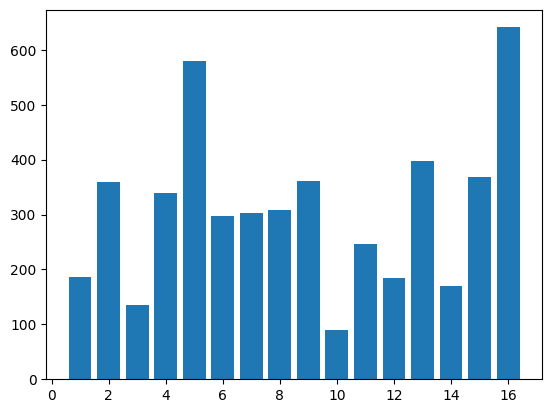

----------------------------------------------------------------------------------------------------
Grade


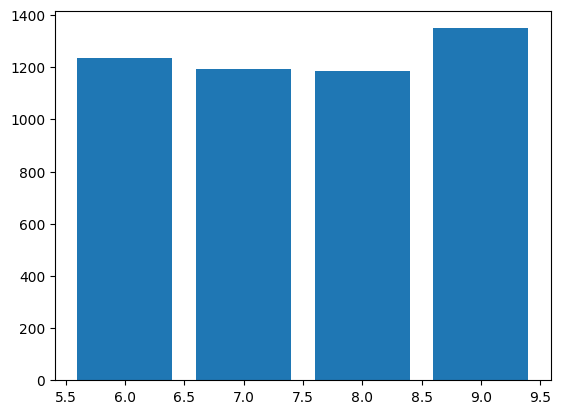

----------------------------------------------------------------------------------------------------
RankingF


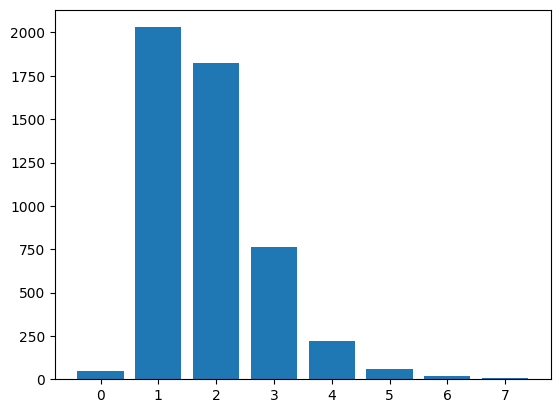

----------------------------------------------------------------------------------------------------
NumberofChi


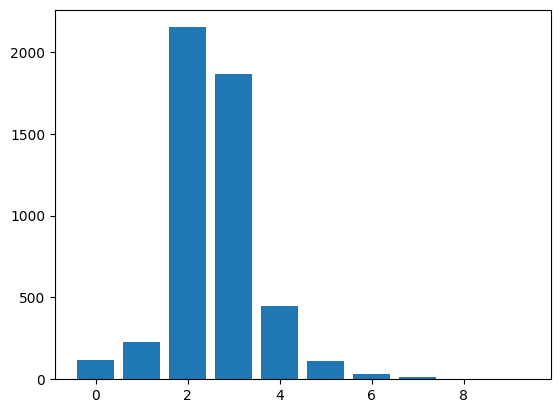

----------------------------------------------------------------------------------------------------
AgeFat


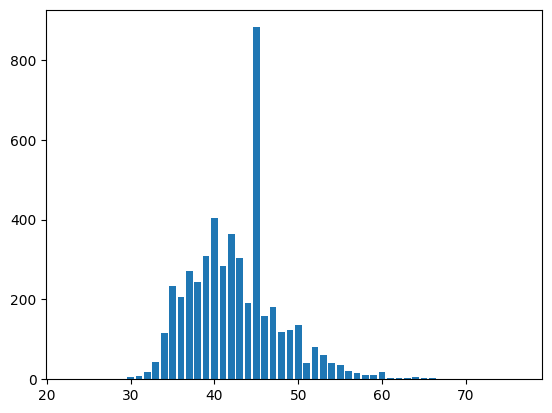

----------------------------------------------------------------------------------------------------
AgeMot


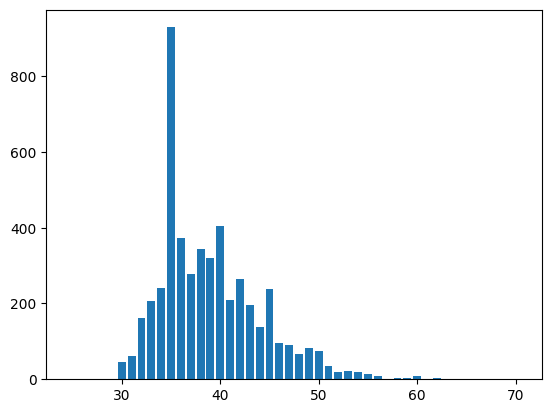

----------------------------------------------------------------------------------------------------
TimeSci


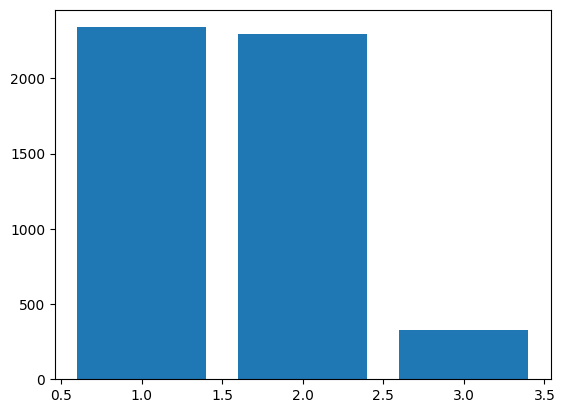

----------------------------------------------------------------------------------------------------
TimeSoc


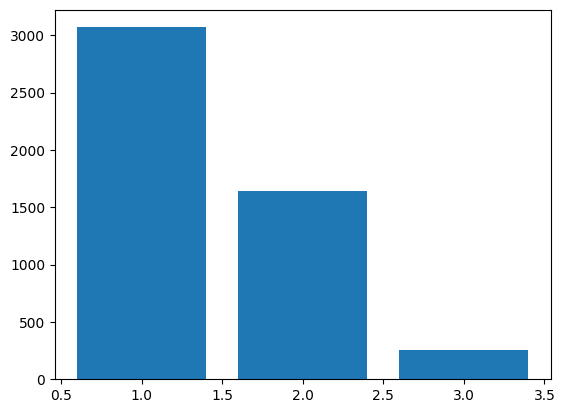

----------------------------------------------------------------------------------------------------
Points


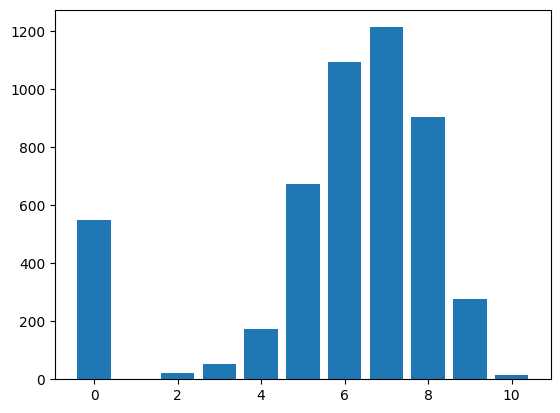

----------------------------------------------------------------------------------------------------
Number_of_typebook


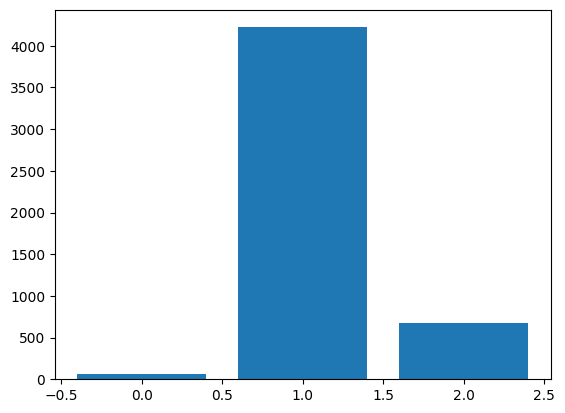

----------------------------------------------------------------------------------------------------


In [27]:
for col in numeric_columns:
  print(col)
  tmp = df[[col, 'label']].groupby(col, as_index=False)['label'].count()
  plt.bar(tmp[col], tmp['label'])
  plt.show()
  print('-'*100)

#### b. Object variables

Sex


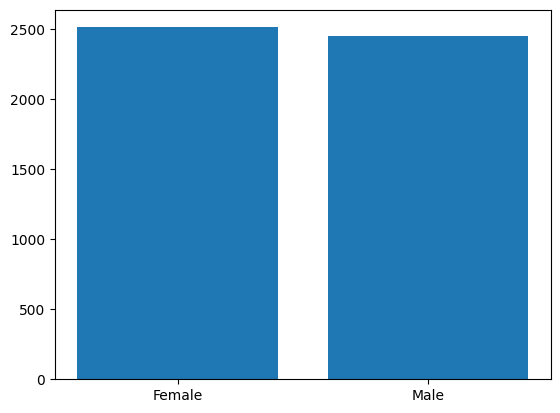

----------------------------------------------------------------------------------------------------
Readbook


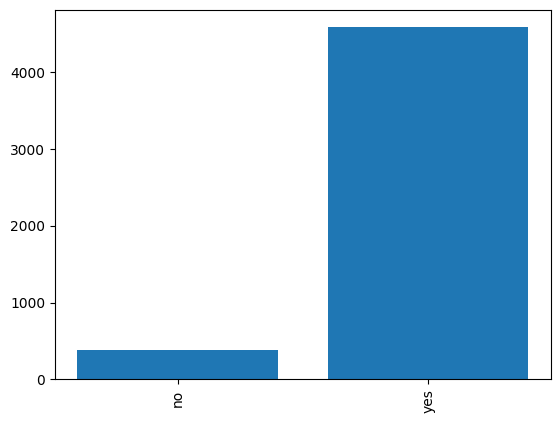

----------------------------------------------------------------------------------------------------
Topic


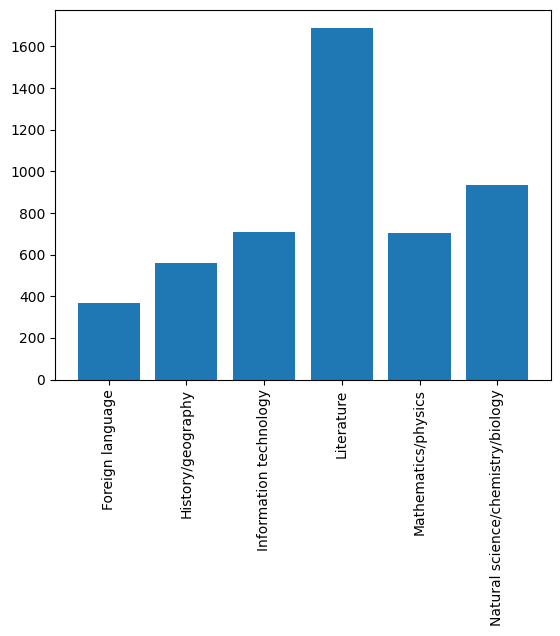

----------------------------------------------------------------------------------------------------
FutureJob


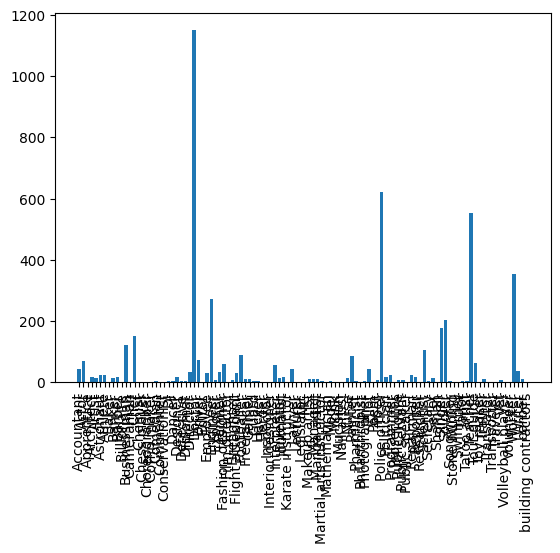

----------------------------------------------------------------------------------------------------
CareerFat


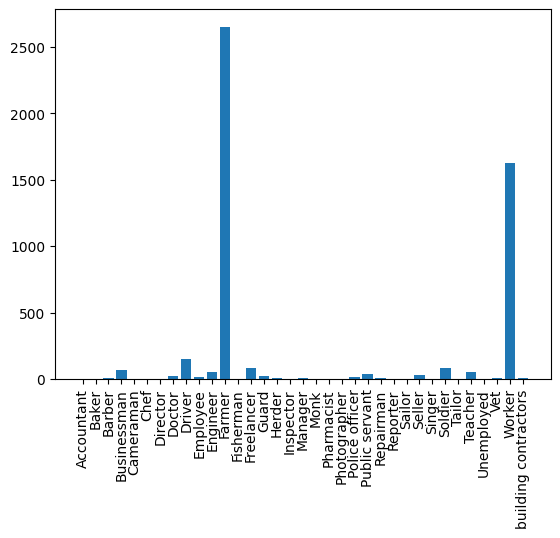

----------------------------------------------------------------------------------------------------
CarFatGr


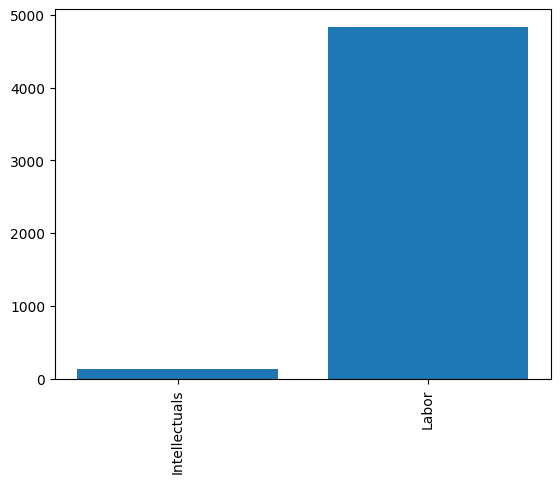

----------------------------------------------------------------------------------------------------
EduFat


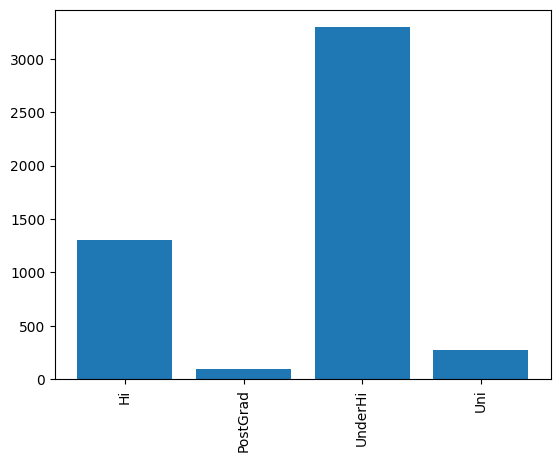

----------------------------------------------------------------------------------------------------
CareerMot


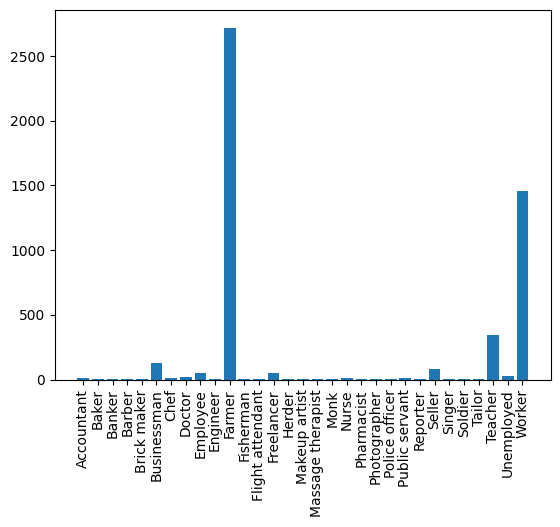

----------------------------------------------------------------------------------------------------
CarMotGr


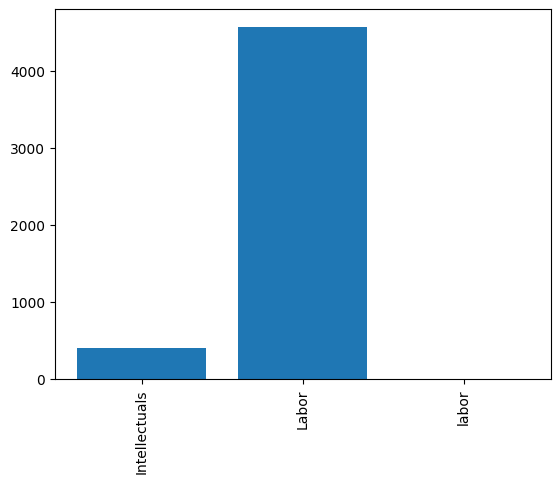

----------------------------------------------------------------------------------------------------
EduMot


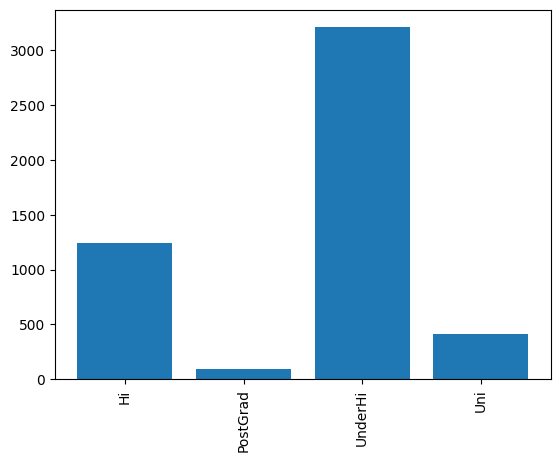

----------------------------------------------------------------------------------------------------
EcoStt


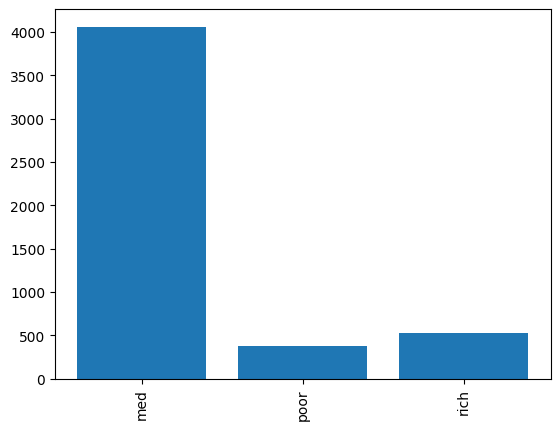

----------------------------------------------------------------------------------------------------
KnowledgeInc


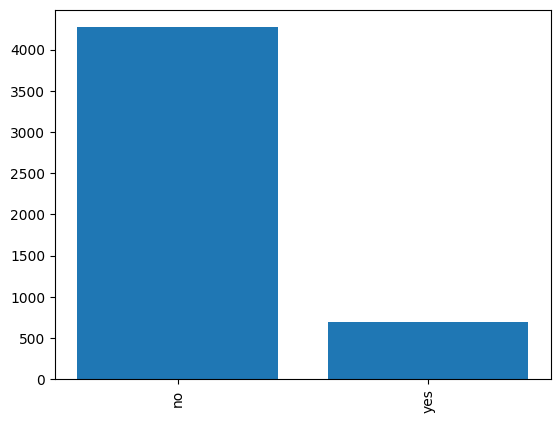

----------------------------------------------------------------------------------------------------
Buybook


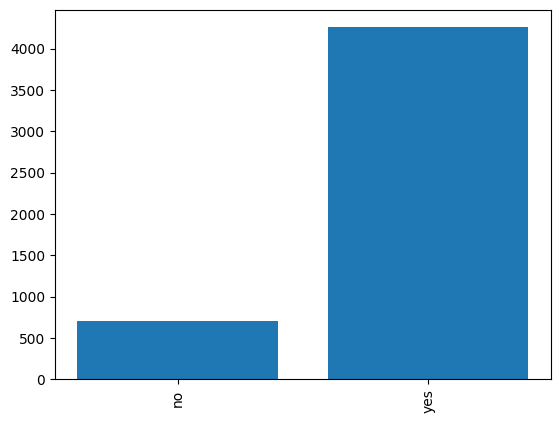

----------------------------------------------------------------------------------------------------
Hobby


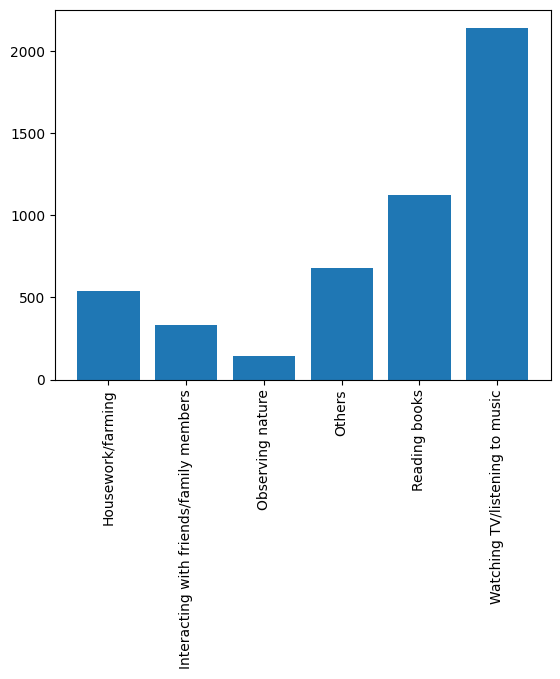

----------------------------------------------------------------------------------------------------
Readstory


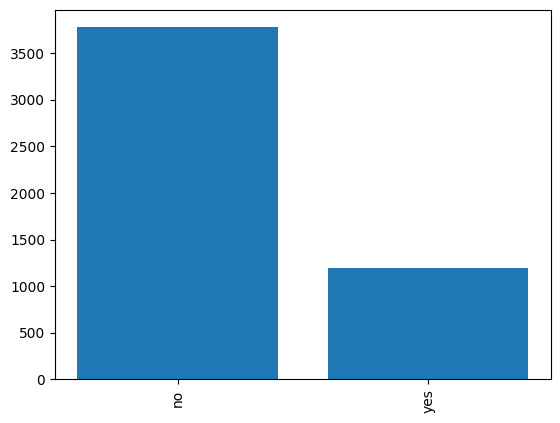

----------------------------------------------------------------------------------------------------
Typebook


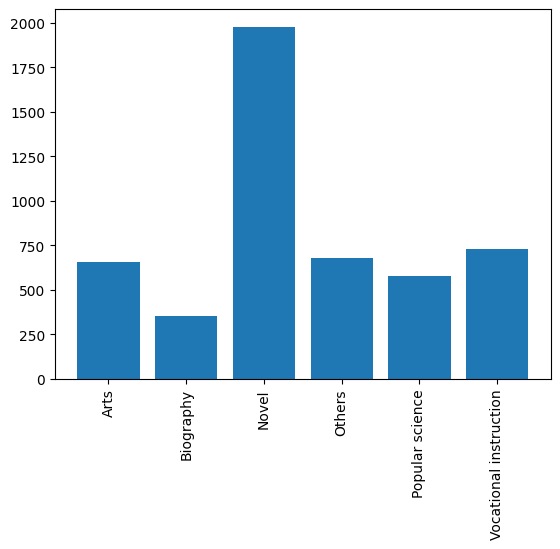

----------------------------------------------------------------------------------------------------
Reason


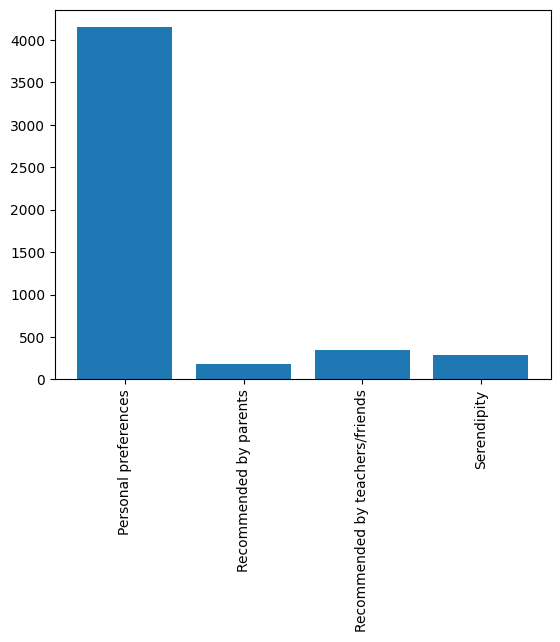

----------------------------------------------------------------------------------------------------
Source


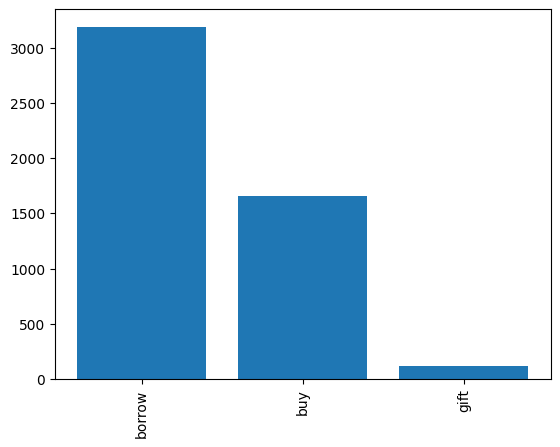

----------------------------------------------------------------------------------------------------
PrioAct


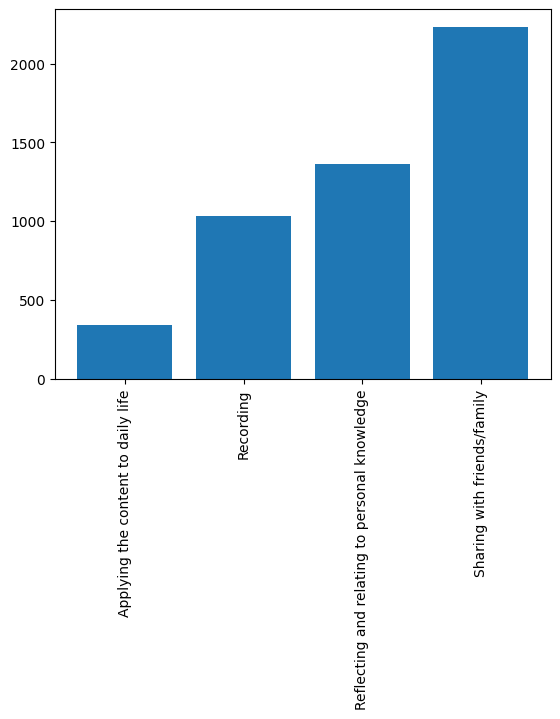

----------------------------------------------------------------------------------------------------
AftAct


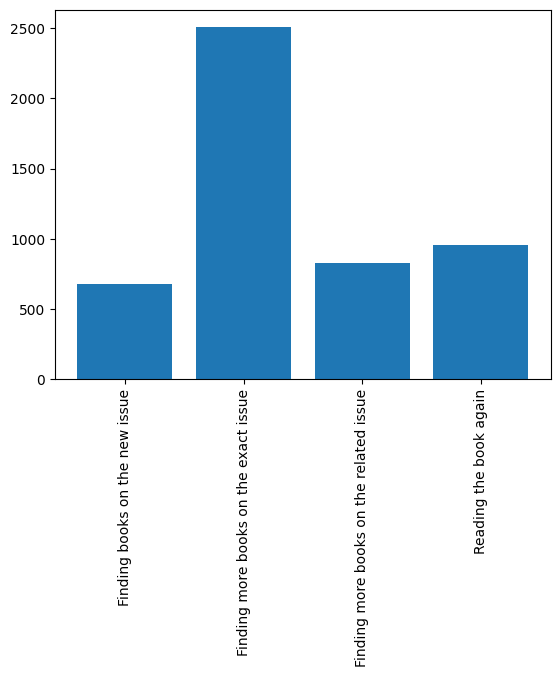

----------------------------------------------------------------------------------------------------
EncourAct


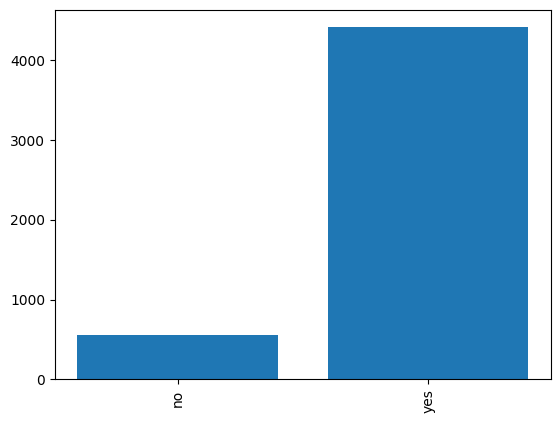

----------------------------------------------------------------------------------------------------
MostlikedAct


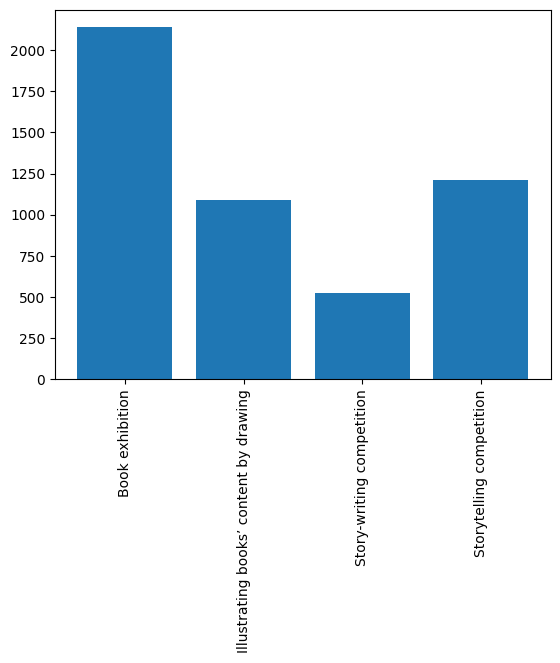

----------------------------------------------------------------------------------------------------
Bookcase


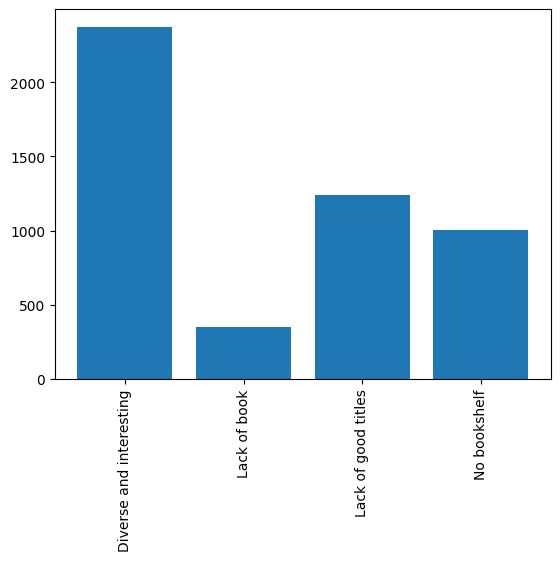

----------------------------------------------------------------------------------------------------


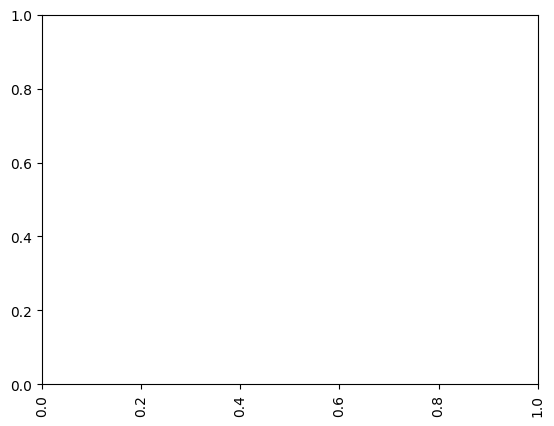

In [28]:
for col in object_columns:
  print(col)
  tmp = df[[col, 'label']].groupby(col, as_index=False)['label'].count()
  # plt.figure(figsize=(15,10))
  plt.bar(tmp[col], tmp['label'])
  plt.show()
  plt.xticks(rotation=90)
  print('-'*100)

## Variable analysis for each label

#### a. Numeric columns

School


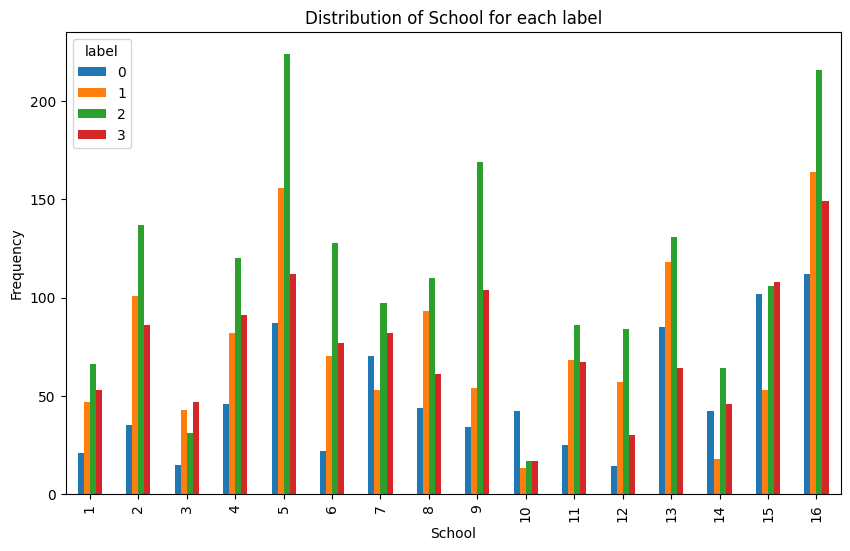

----------------------------------------------------------------------------------------------------
Grade


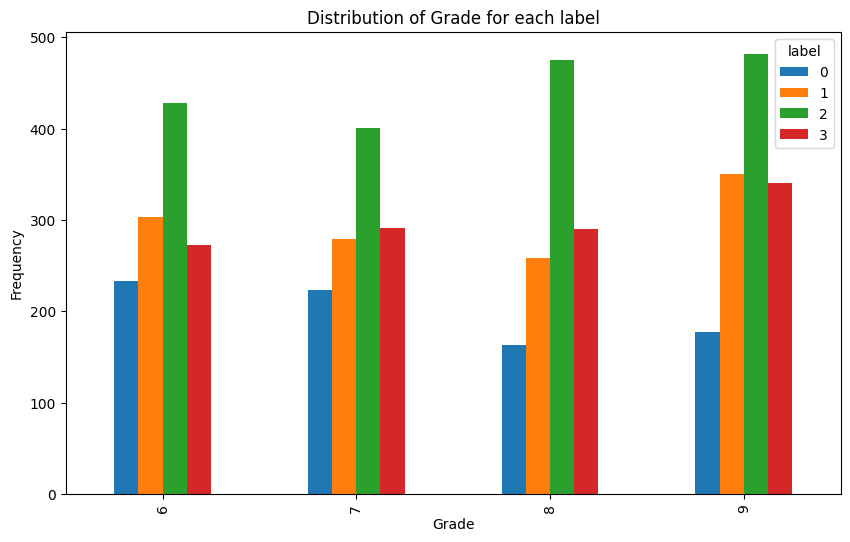

----------------------------------------------------------------------------------------------------
RankingF


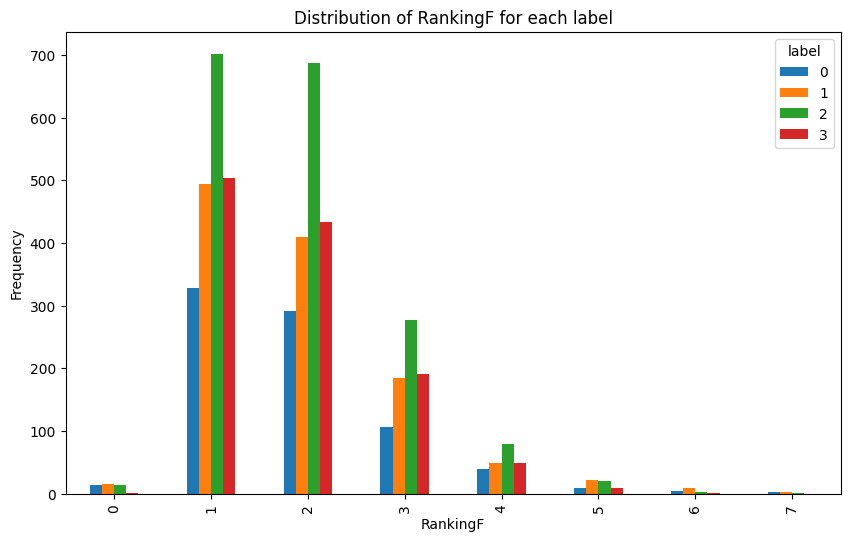

----------------------------------------------------------------------------------------------------
NumberofChi


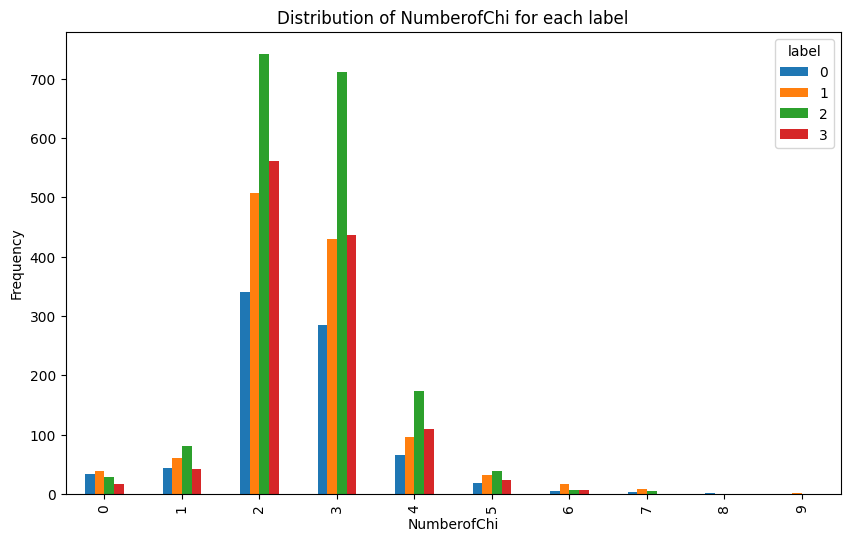

----------------------------------------------------------------------------------------------------
AgeFat


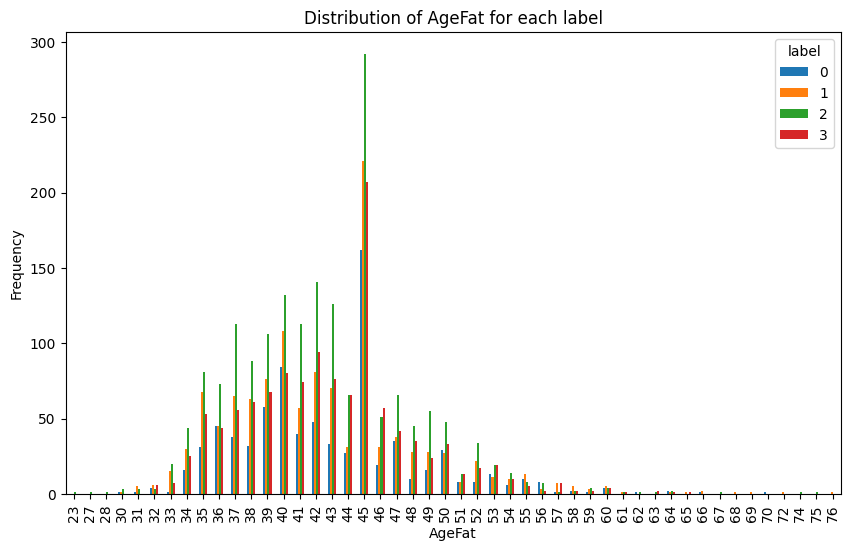

----------------------------------------------------------------------------------------------------
AgeMot


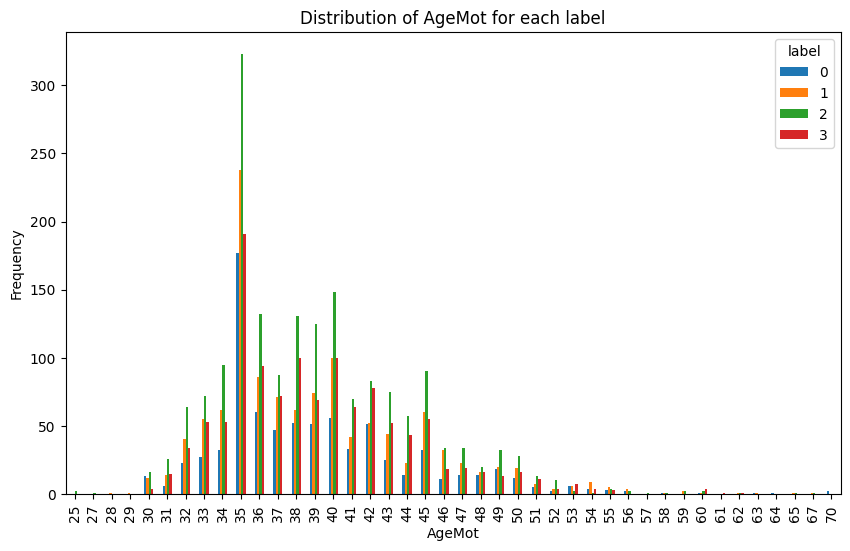

----------------------------------------------------------------------------------------------------
TimeSci


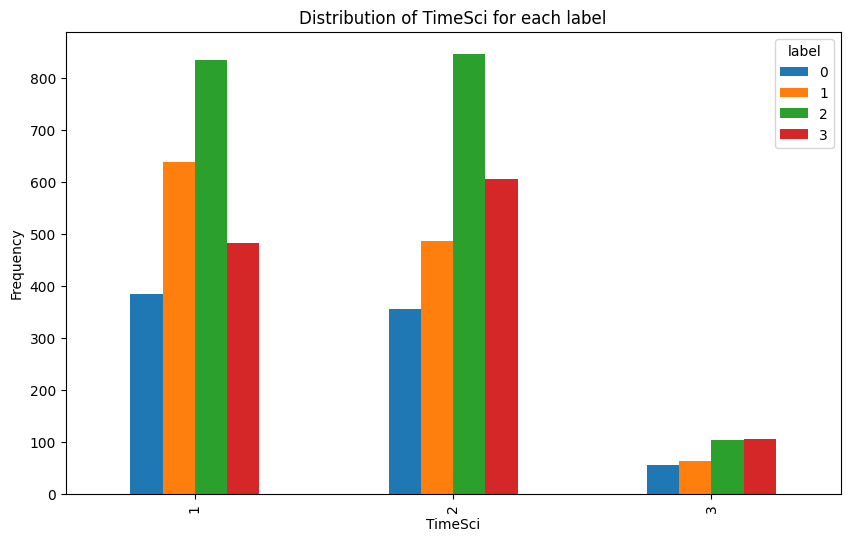

----------------------------------------------------------------------------------------------------
TimeSoc


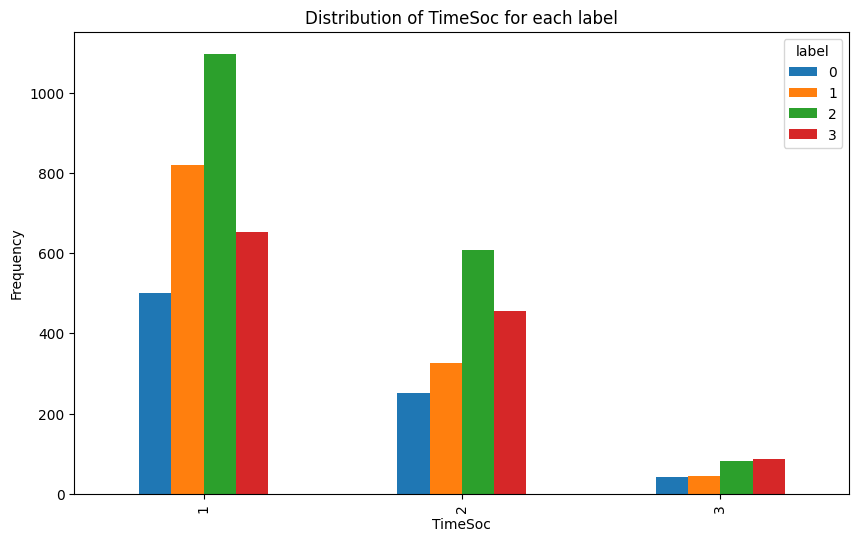

----------------------------------------------------------------------------------------------------
Points


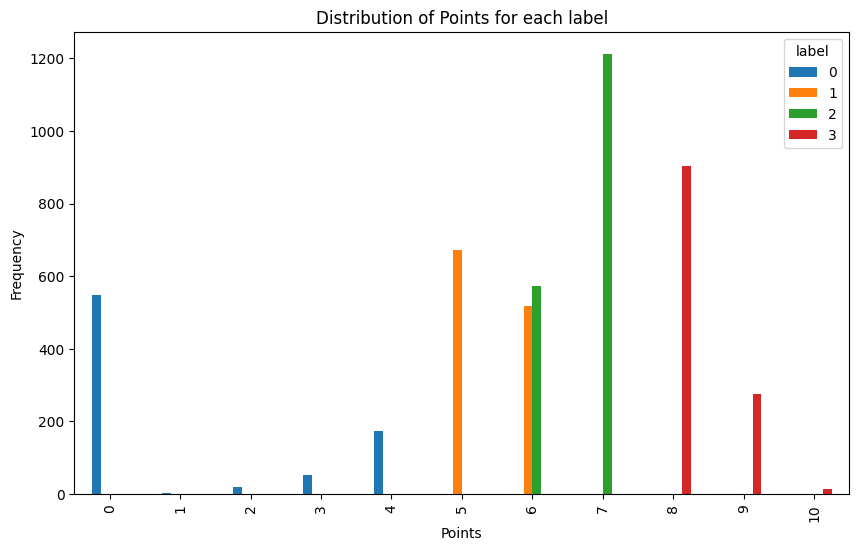

----------------------------------------------------------------------------------------------------
Number_of_typebook


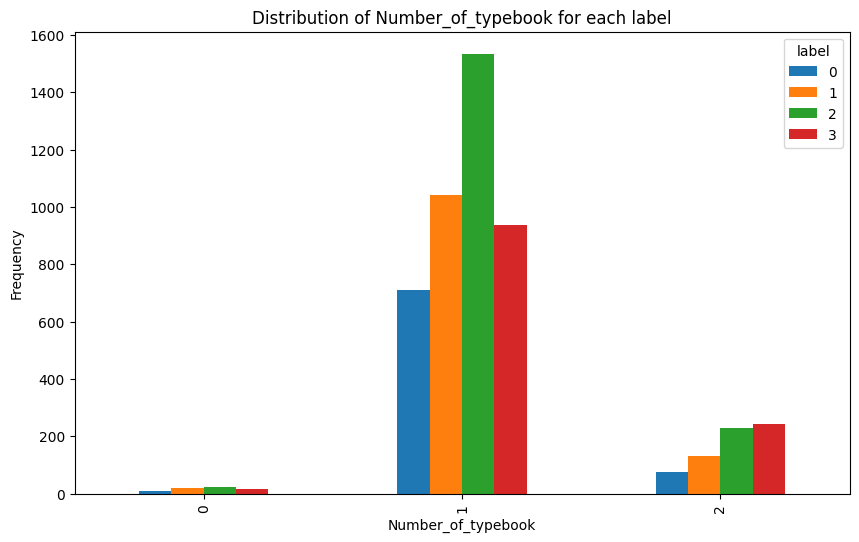

----------------------------------------------------------------------------------------------------


In [29]:
for col in numeric_columns:
  print(col)
  grouped_data = df.groupby([col, 'label'])[col].count().unstack()

  # Plotting
  ax = grouped_data.plot(kind='bar', stacked=False, figsize=(10, 6))

  # Set labels and title
  ax.set_xlabel(col)
  ax.set_ylabel("Frequency")
  plt.title(f"Distribution of {col} for each label")
  plt.legend(title='label')

  # Show the plot
  plt.show()
  print('-'*100)

#### b. Object variables

Sex


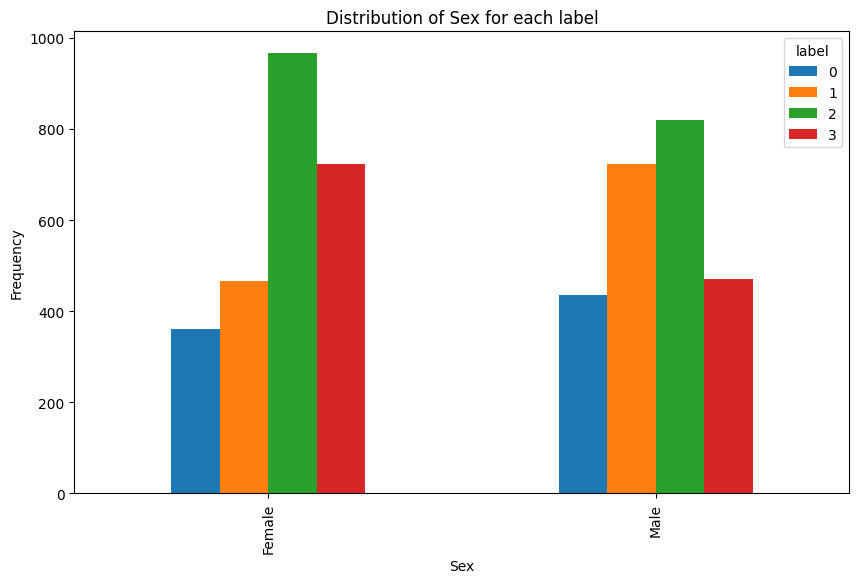

----------------------------------------------------------------------------------------------------
Readbook


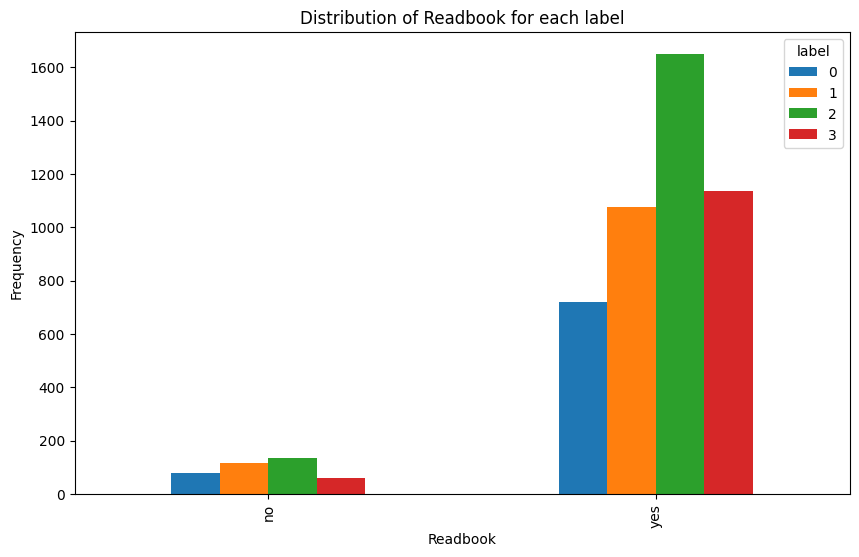

----------------------------------------------------------------------------------------------------
Topic


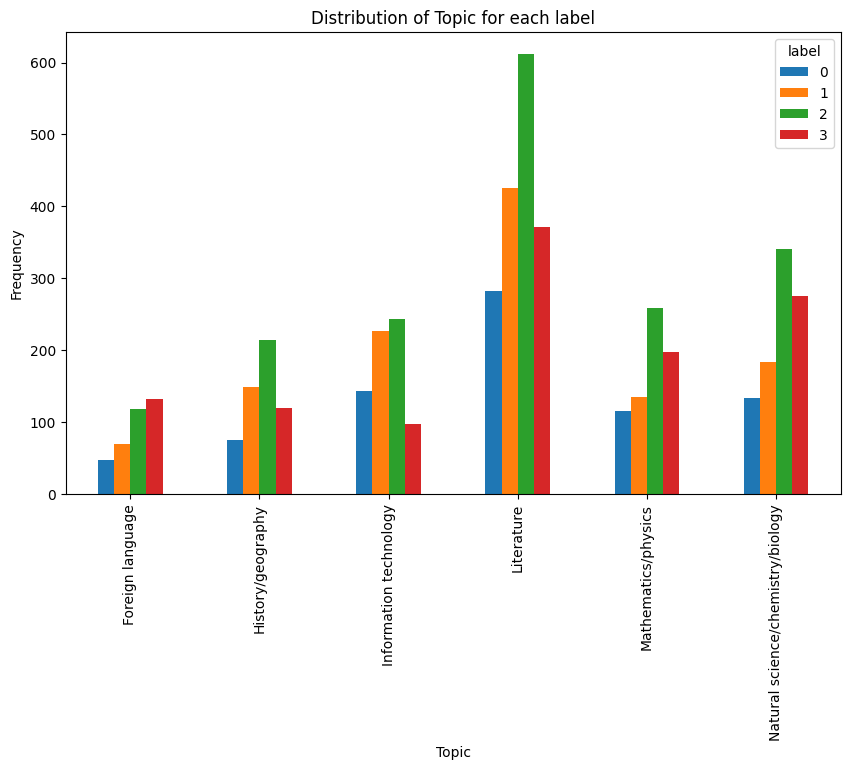

----------------------------------------------------------------------------------------------------
FutureJob


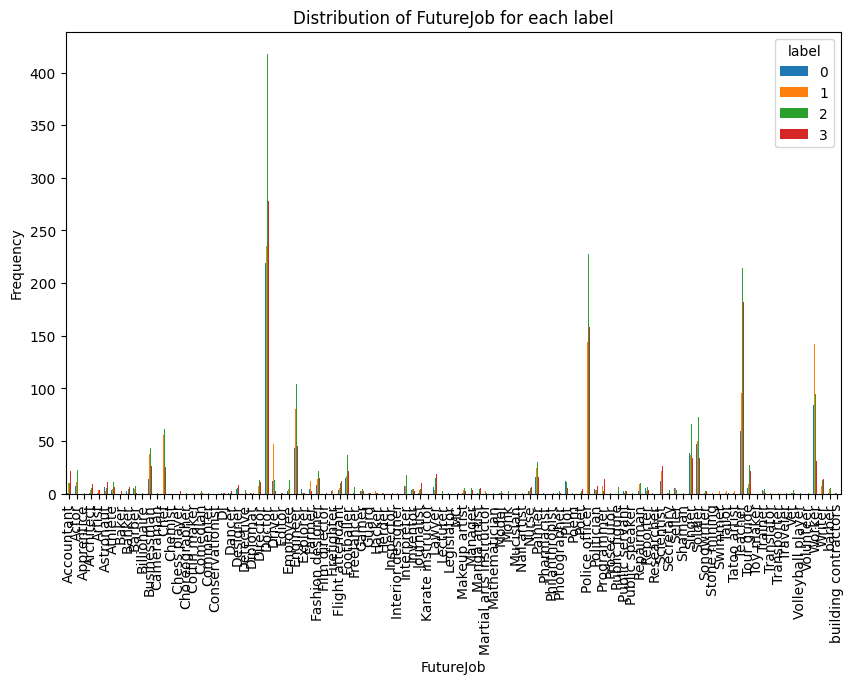

----------------------------------------------------------------------------------------------------
CareerFat


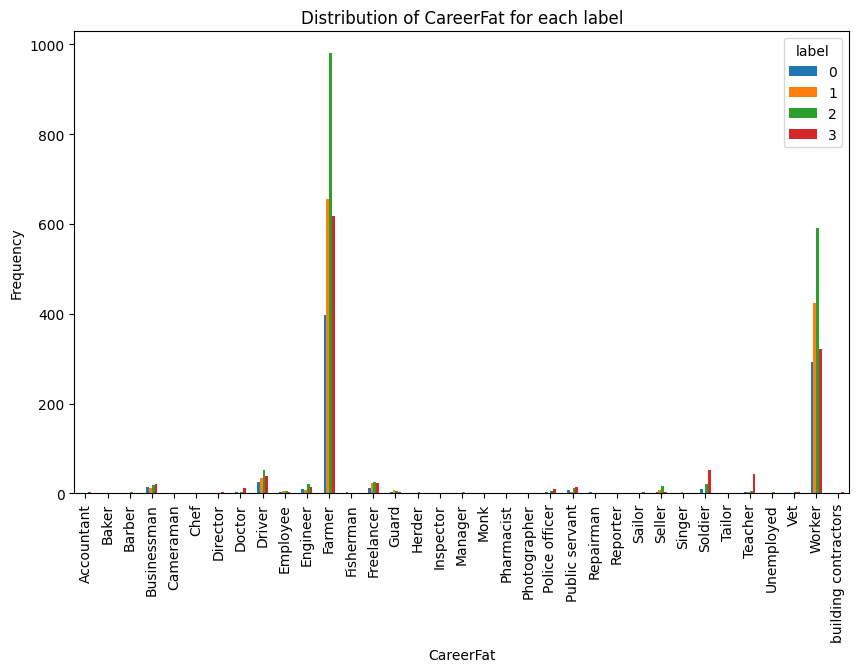

----------------------------------------------------------------------------------------------------
CarFatGr


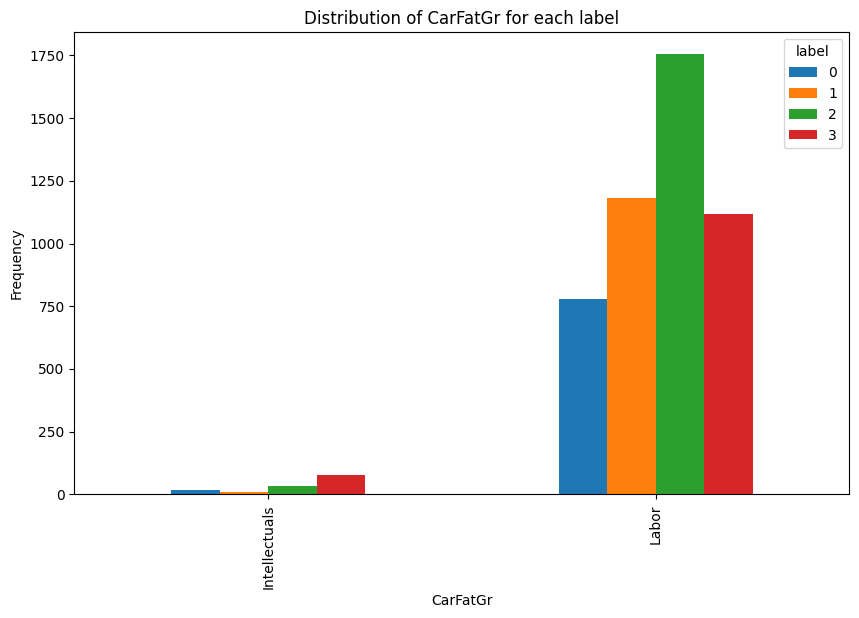

----------------------------------------------------------------------------------------------------
EduFat


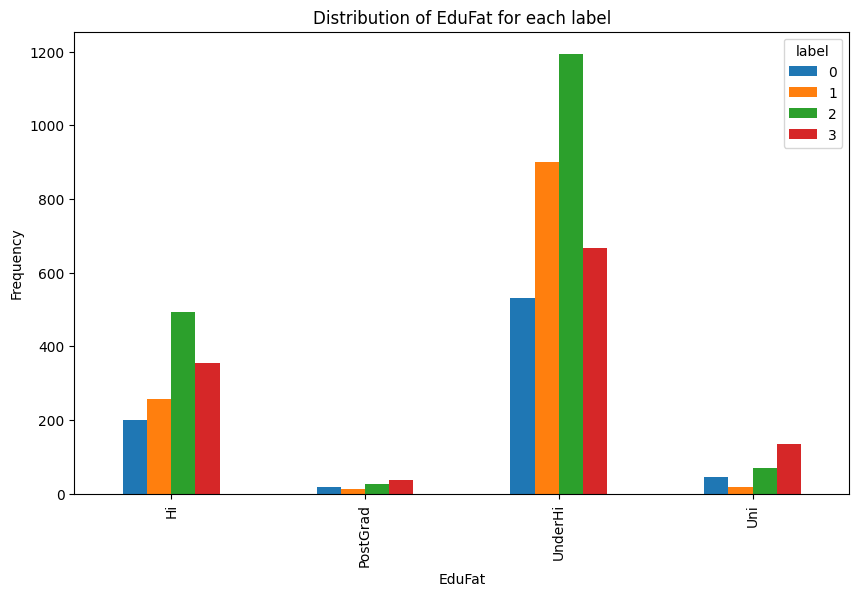

----------------------------------------------------------------------------------------------------
CareerMot


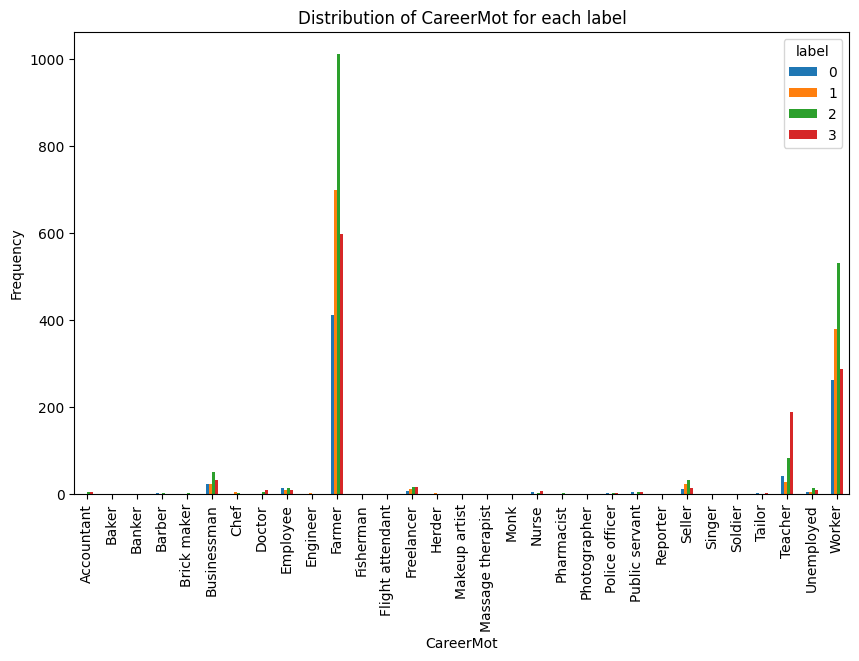

----------------------------------------------------------------------------------------------------
CarMotGr


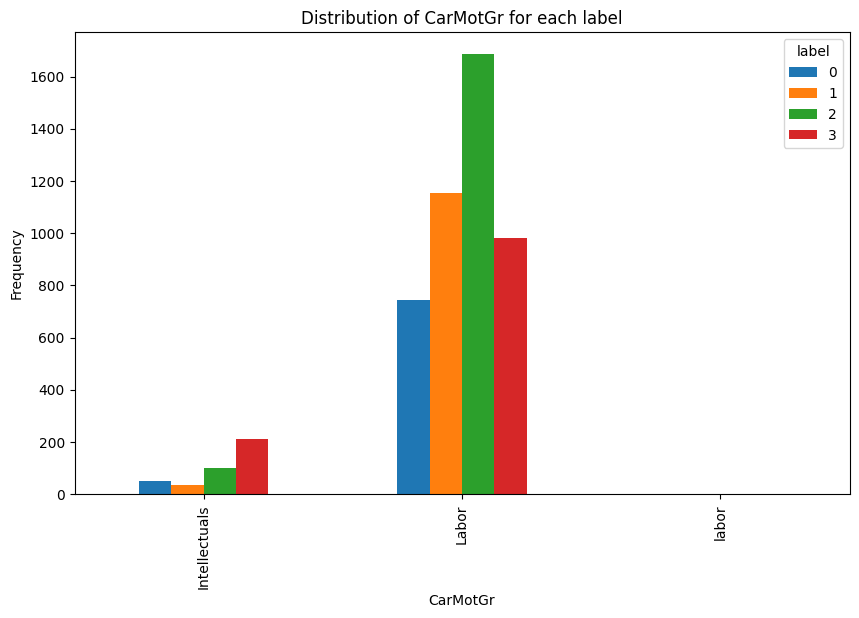

----------------------------------------------------------------------------------------------------
EduMot


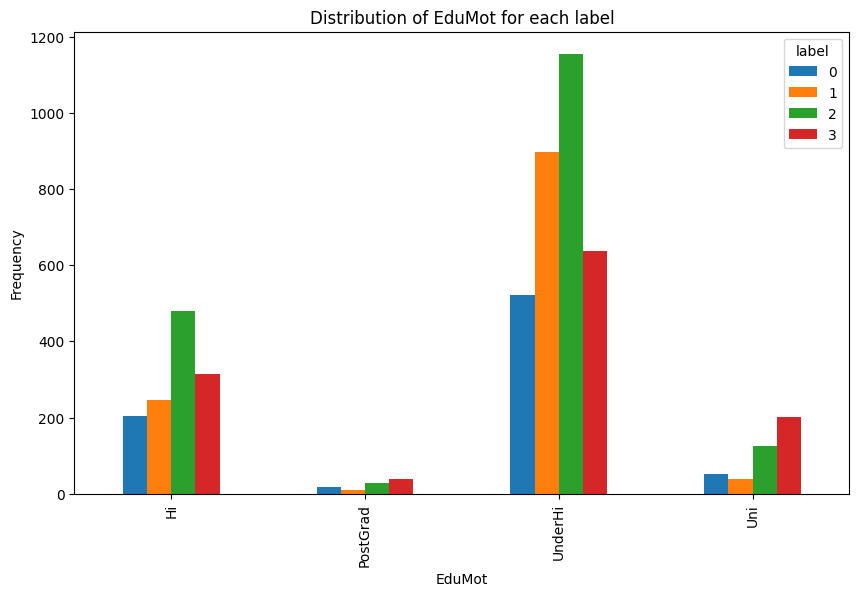

----------------------------------------------------------------------------------------------------
EcoStt


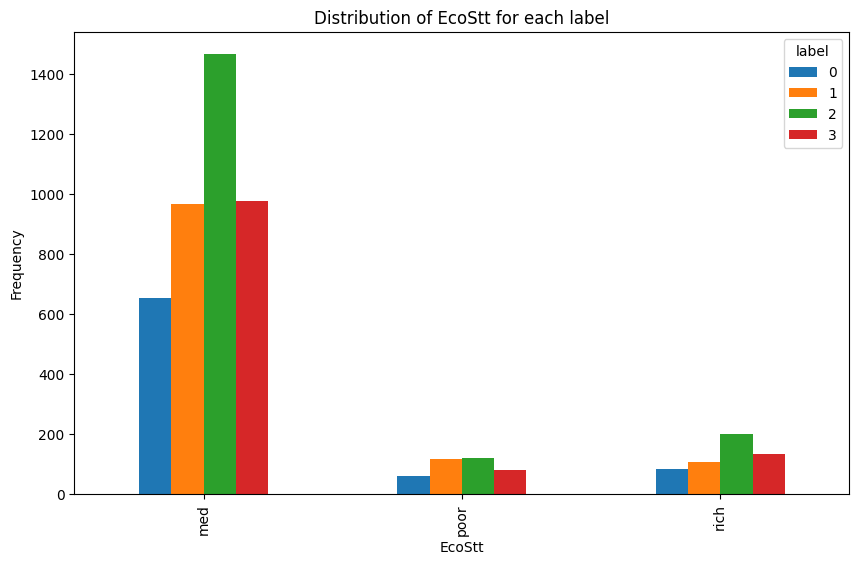

----------------------------------------------------------------------------------------------------
KnowledgeInc


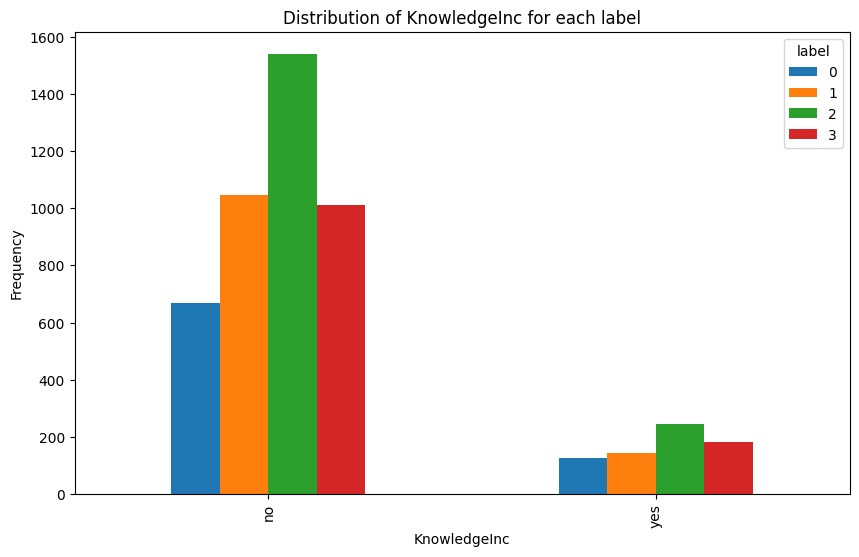

----------------------------------------------------------------------------------------------------
Buybook


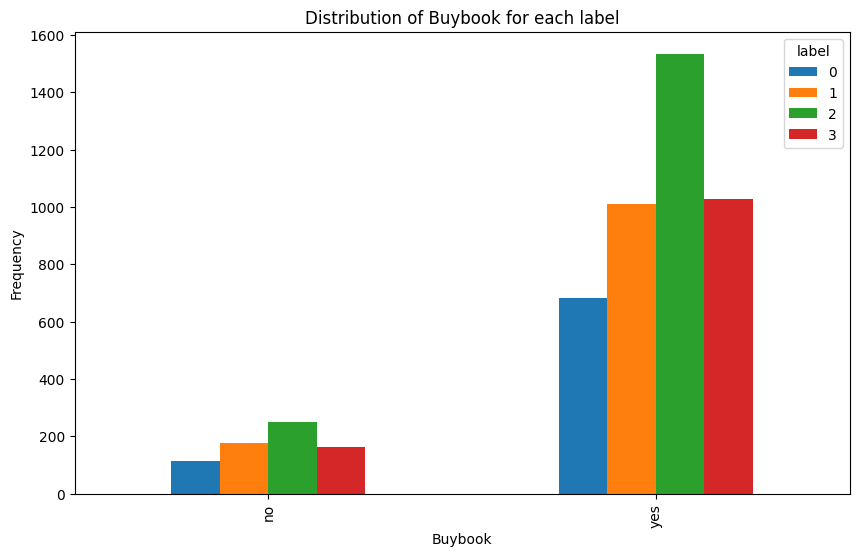

----------------------------------------------------------------------------------------------------
Hobby


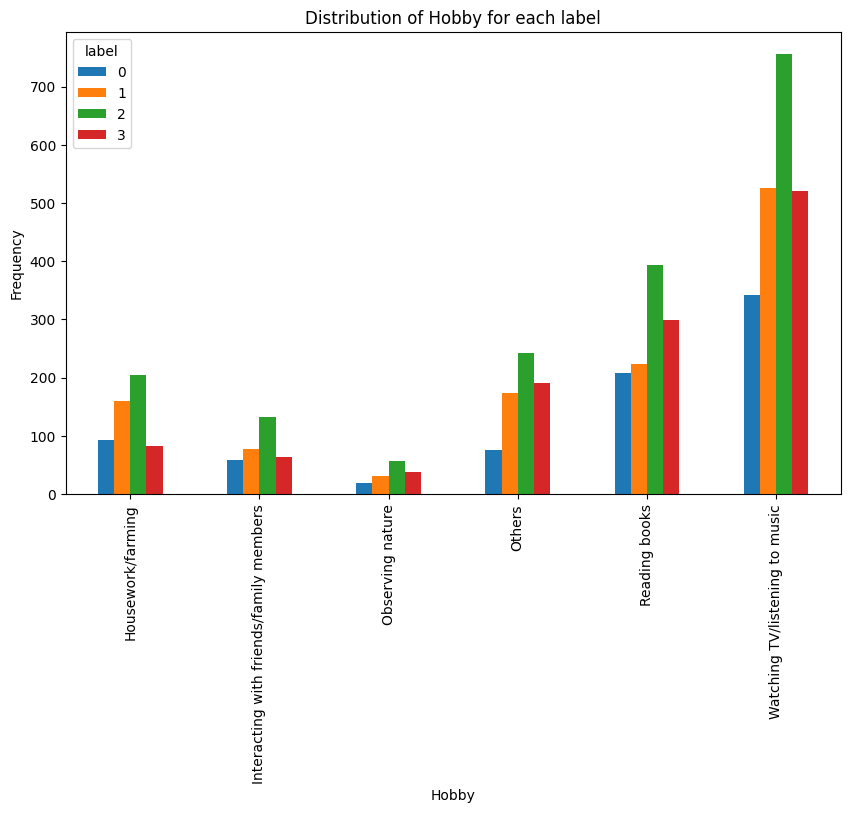

----------------------------------------------------------------------------------------------------
Readstory


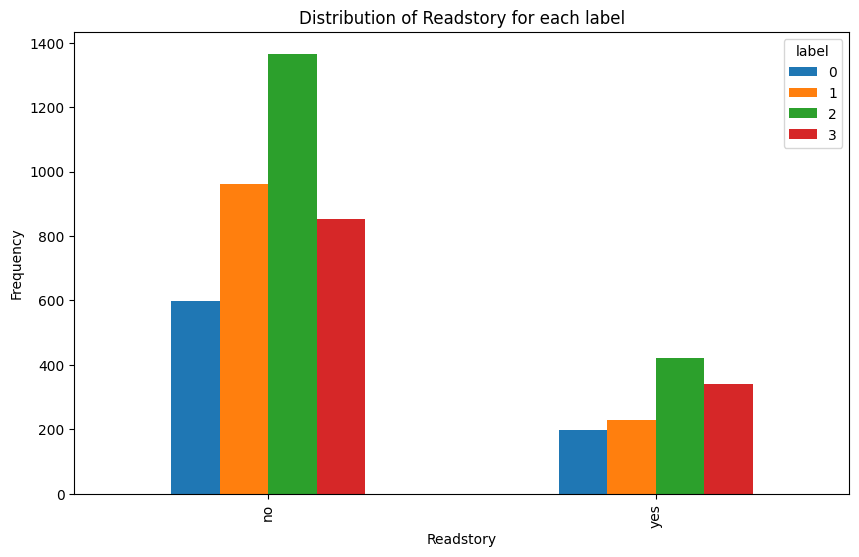

----------------------------------------------------------------------------------------------------
Typebook


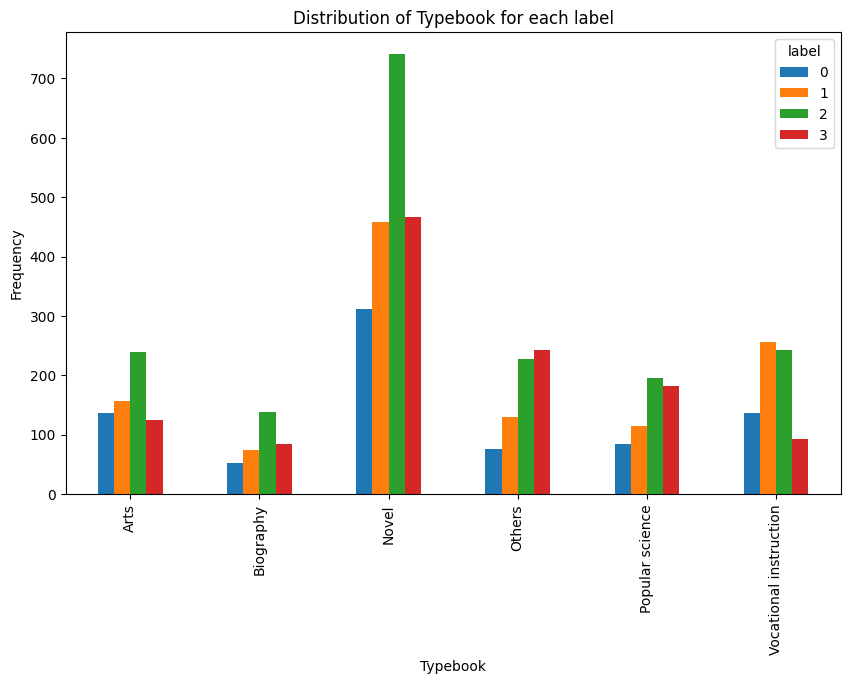

----------------------------------------------------------------------------------------------------
Reason


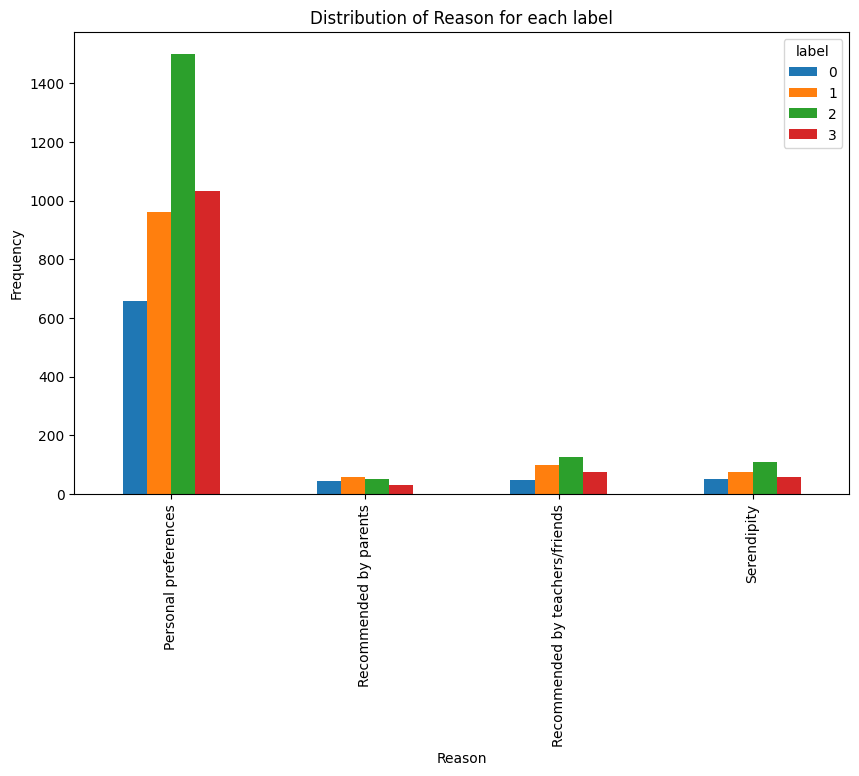

----------------------------------------------------------------------------------------------------
Source


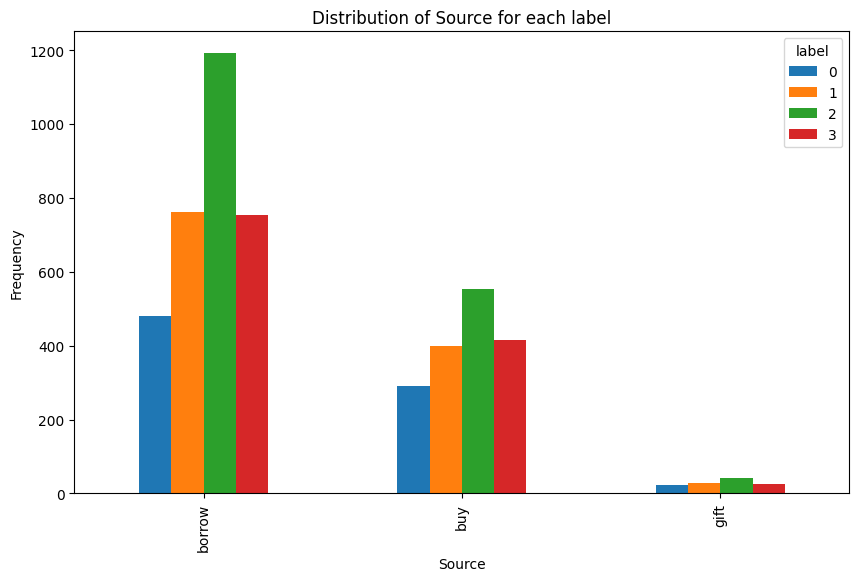

----------------------------------------------------------------------------------------------------
PrioAct


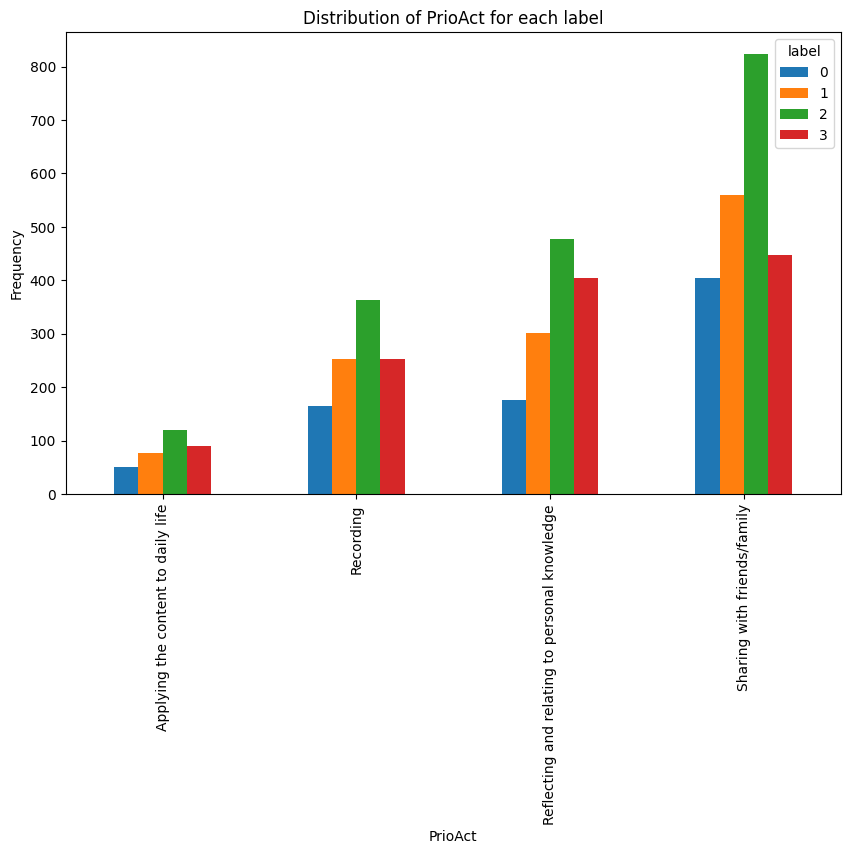

----------------------------------------------------------------------------------------------------
AftAct


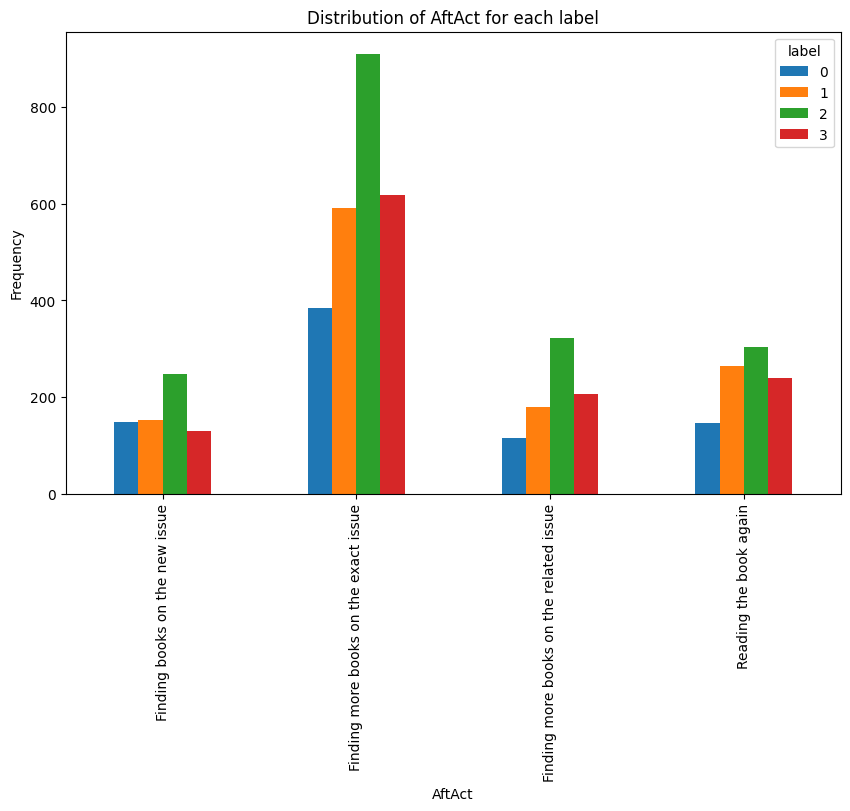

----------------------------------------------------------------------------------------------------
EncourAct


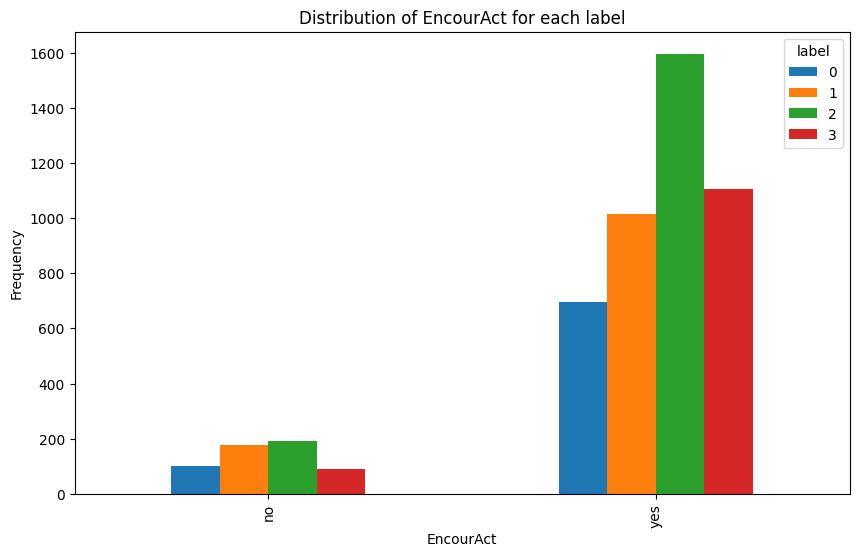

----------------------------------------------------------------------------------------------------
MostlikedAct


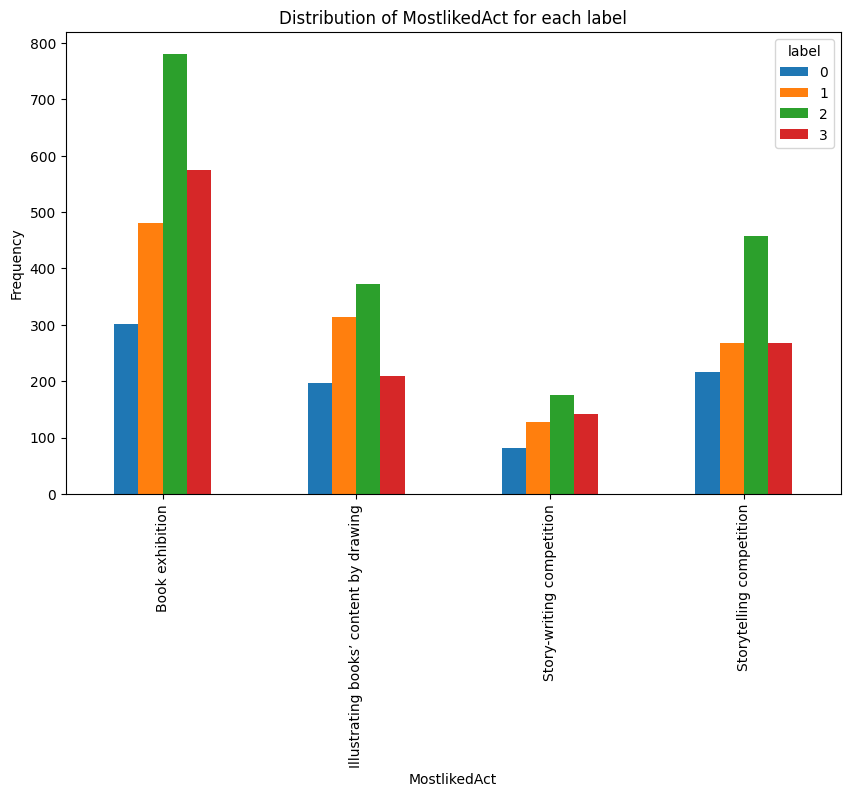

----------------------------------------------------------------------------------------------------
Bookcase


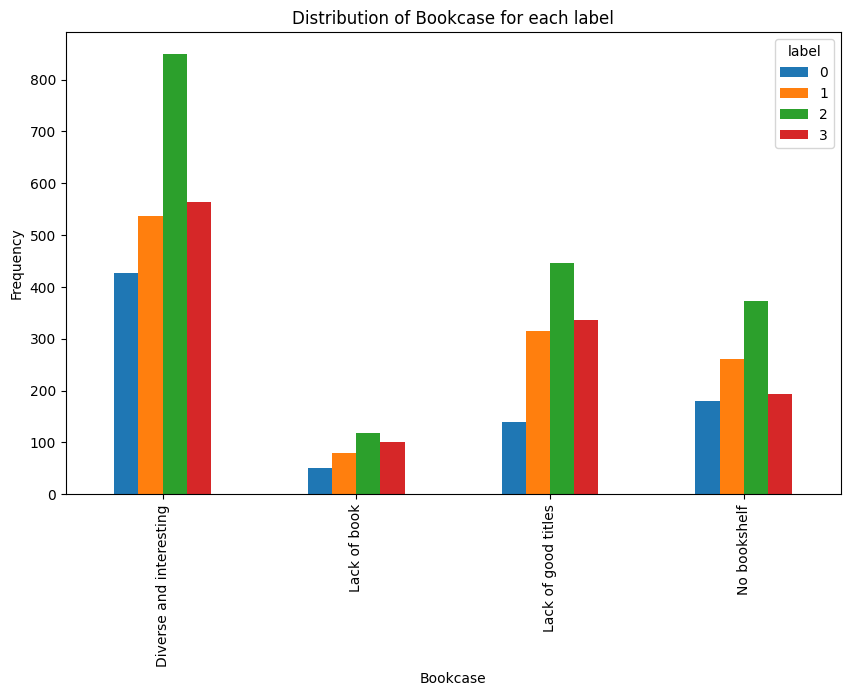

----------------------------------------------------------------------------------------------------


In [30]:
for col in object_columns:
  print(col)
  grouped_data = df.groupby([col, 'label'])[col].count().unstack()

  # Plotting
  ax = grouped_data.plot(kind='bar', stacked=False, figsize=(10, 6))

  # Set labels and title
  ax.set_xlabel(col)
  ax.set_ylabel("Frequency")
  plt.title(f"Distribution of {col} for each label")
  plt.legend(title='label')

  # Show the plot
  plt.show()
  print('-'*100)

# POINTS DISTRIBUTION

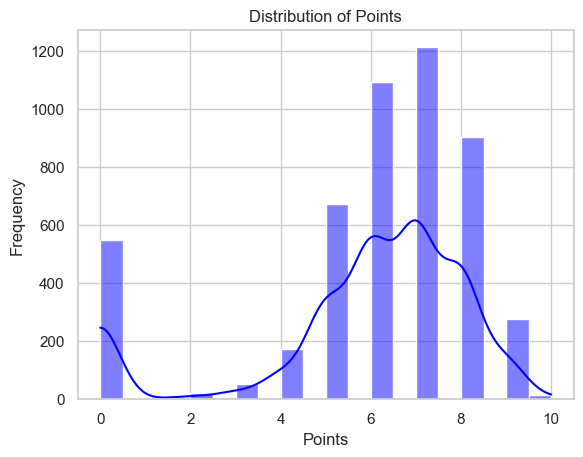

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style
sns.set(style="whitegrid")
sns.histplot(df['Points'], kde=True, bins=20, color='blue')
plt.title(f"Distribution of Points")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()

Points appears to have a slightly left-skewed distribution.

Majority: 6-8 points

# GENDER AND LABEL DISTRIBUTION: A count plot showing how labels are distributed across sexes, providing insight into any gender-based differences.

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\1698849683.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='muted')


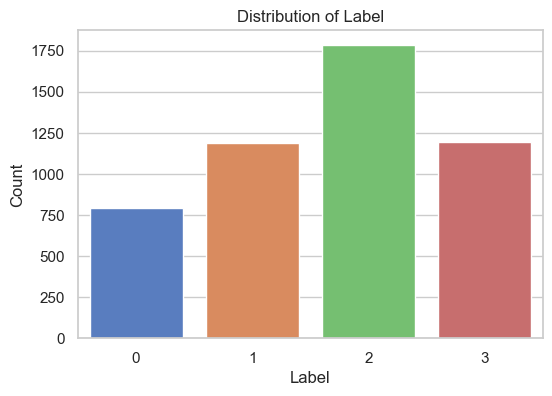

In [32]:
# Distribution of the target variable `label`
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='muted')
plt.title("Distribution of Label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

*General*: Smarter/more clever students in the class (Label 3 and 4)

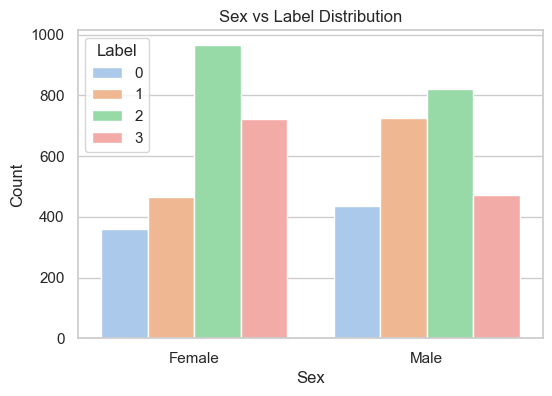

In [33]:
# Relationship between Sex and label
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', hue='label', data=df, palette='pastel')
plt.title("Sex vs Label Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Label")
plt.show()

4: HIGHEST, 1: LOWEST

Both female and male have the highest label (points) at 3

Female students has more achievement than male students do (more 4 in female)

# Frequency of values in key categorical features: Hobby, Bookcase and Points

The student’s perception of the classroom’s bookshelf condition

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\3061819374.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='pastel', order=df[feature].value_counts().index)


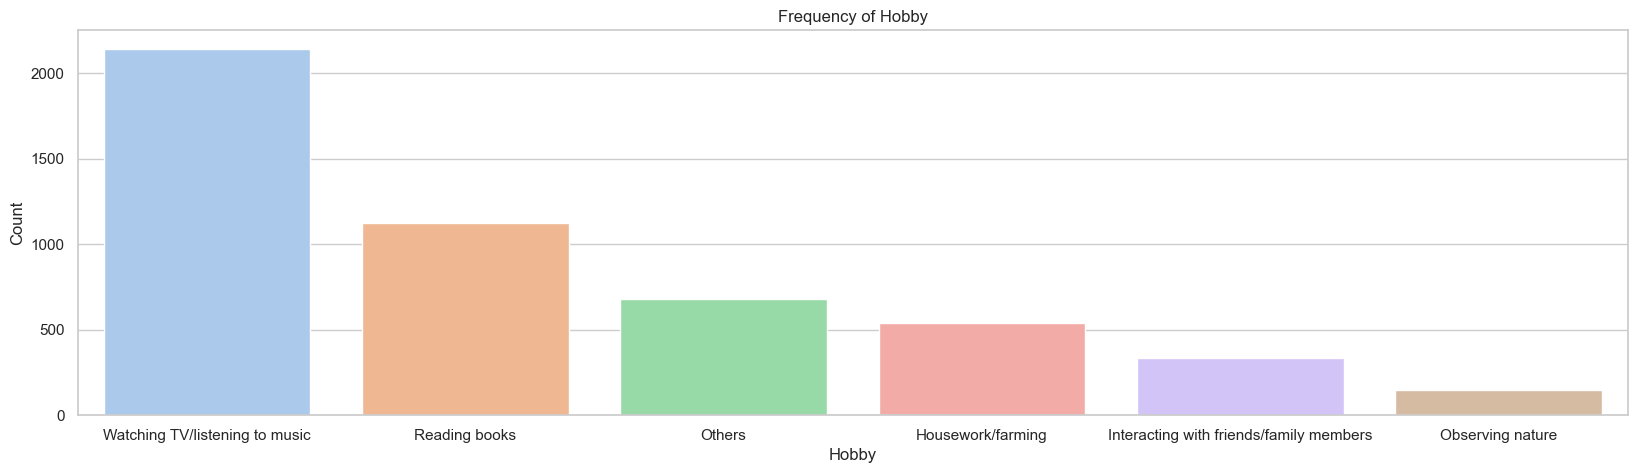

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\3061819374.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette='pastel', order=df[feature].value_counts().index)


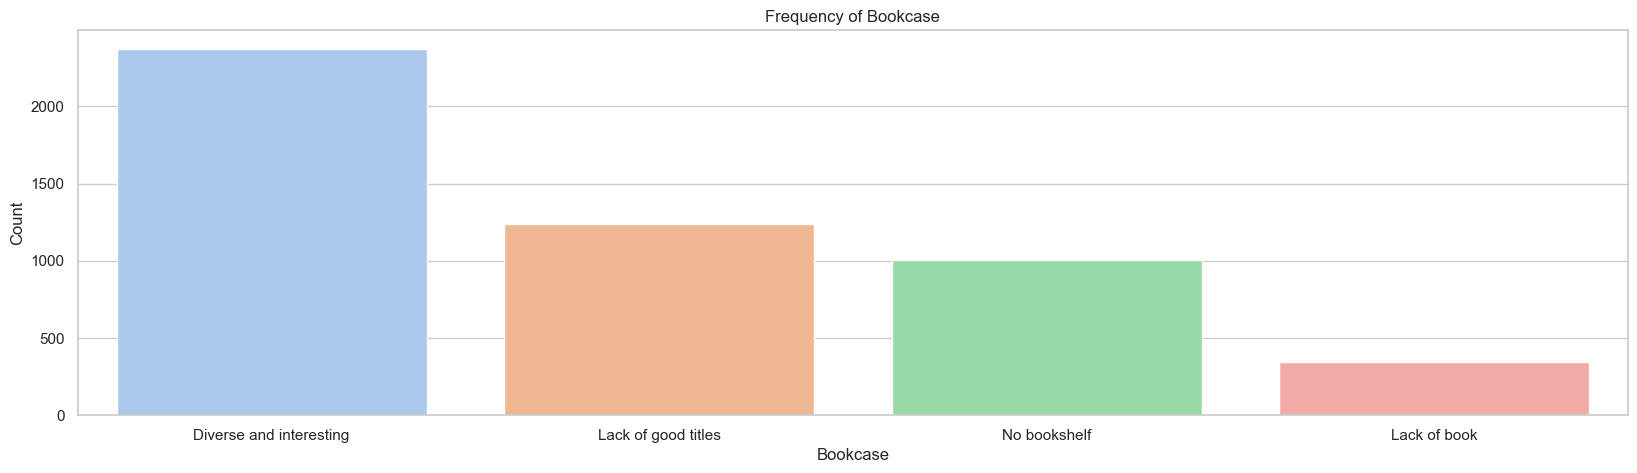

In [34]:
# 2. Frequency of values in key categorical features
categorical_features = ['Hobby', 'Bookcase']
for feature in categorical_features:
    plt.figure(figsize=(20, 5))
    sns.countplot(x=feature, data=df, palette='pastel', order=df[feature].value_counts().index)
    plt.title(f"Frequency of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\2243998404.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')


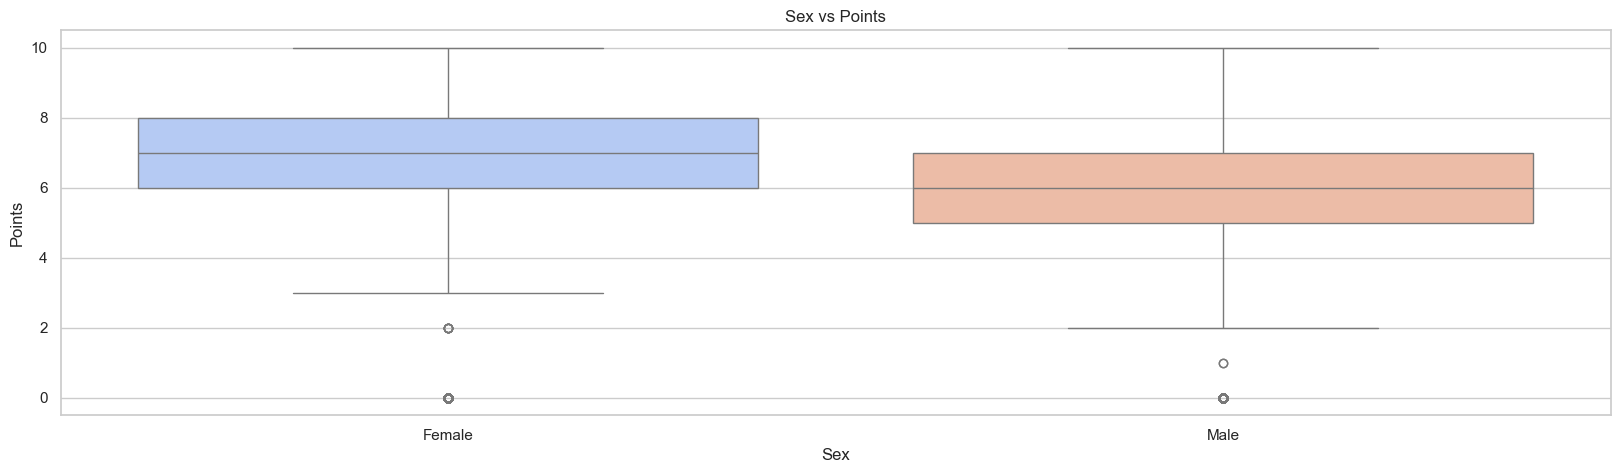

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\2243998404.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')


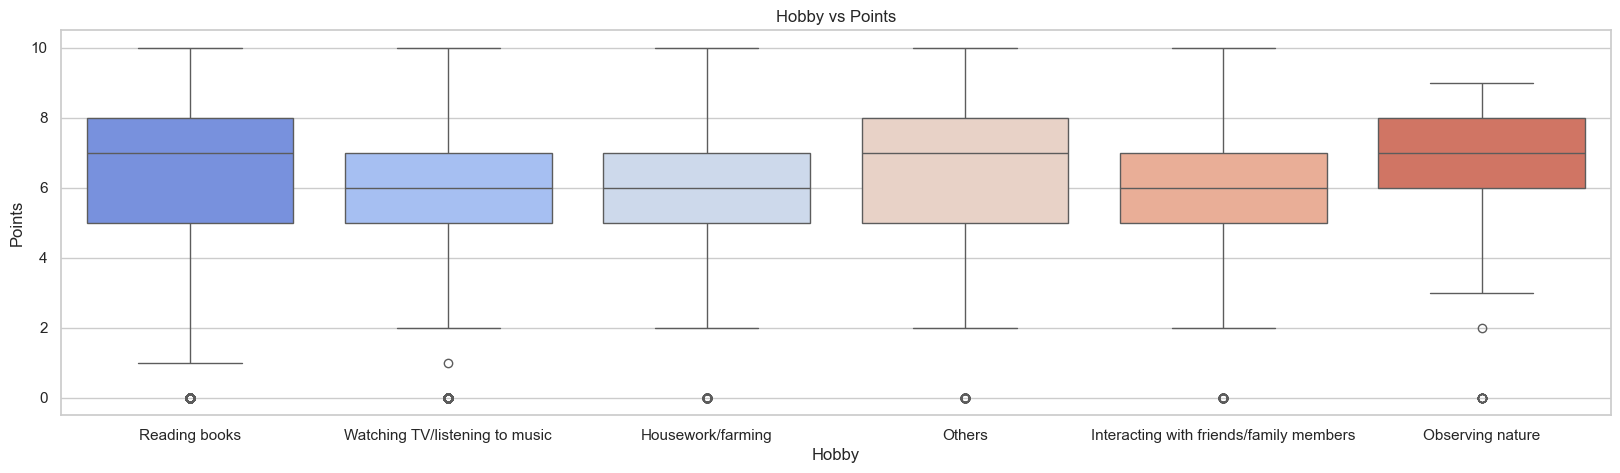

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\2243998404.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')


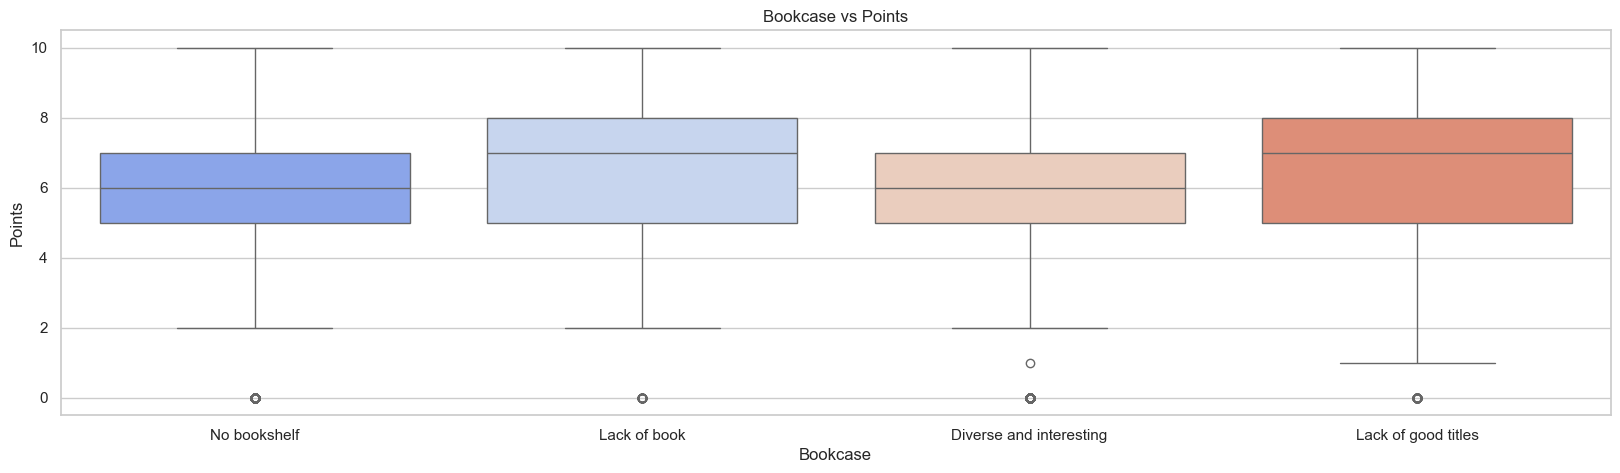

In [35]:
# 4. Categorical features vs Points
categorical_features_vs_points = ['Sex', 'Hobby', 'Bookcase']
for feature in categorical_features_vs_points:
    plt.figure(figsize=(20,5))
    sns.boxplot(x=feature, y='Points', data=df, palette='coolwarm')
    plt.title(f"{feature} vs Points")
    plt.xlabel(feature)
    plt.ylabel("Points")
    plt.show()


C:\Users\hient\AppData\Local\Temp\ipykernel_19932\1188859714.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')


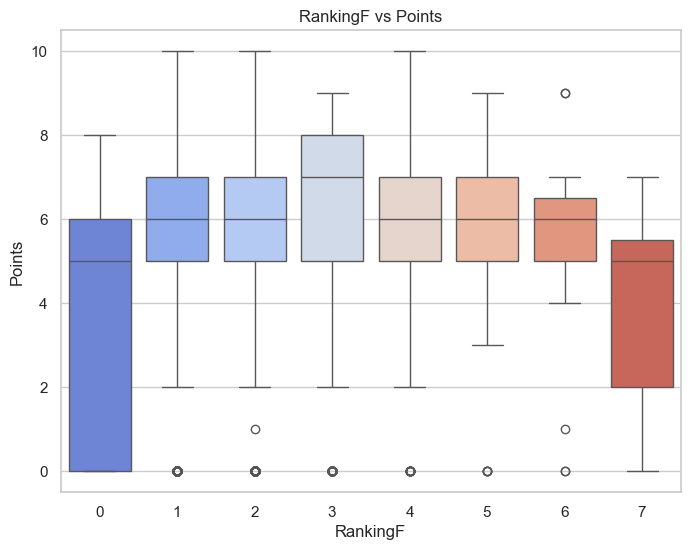

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\1188859714.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')


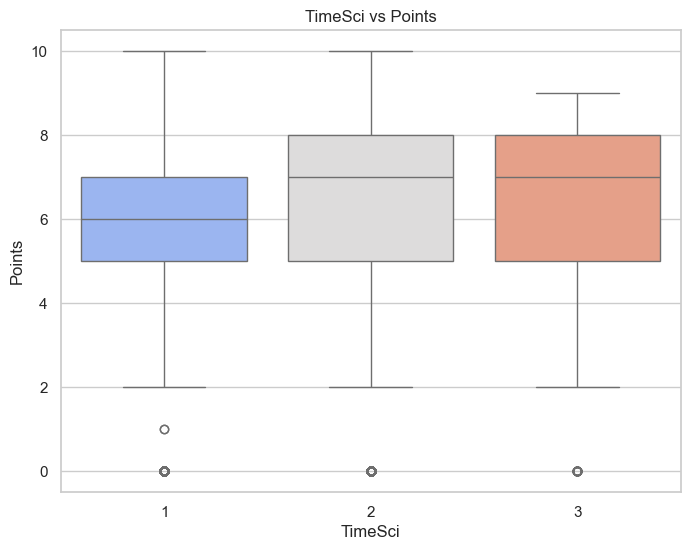

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\1188859714.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')


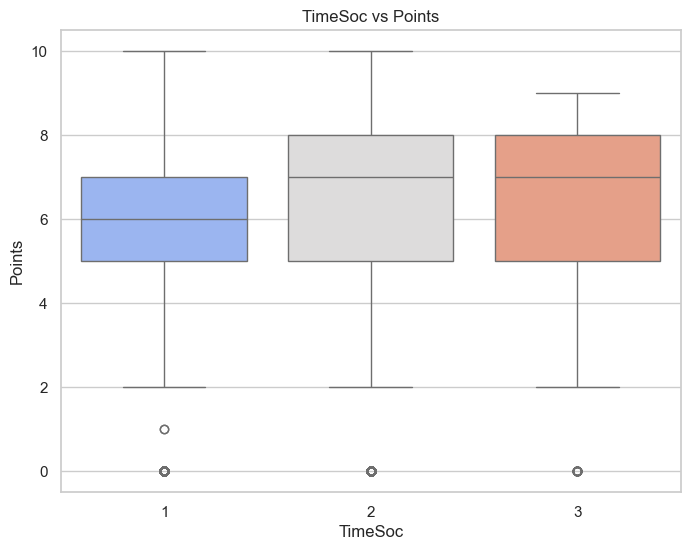

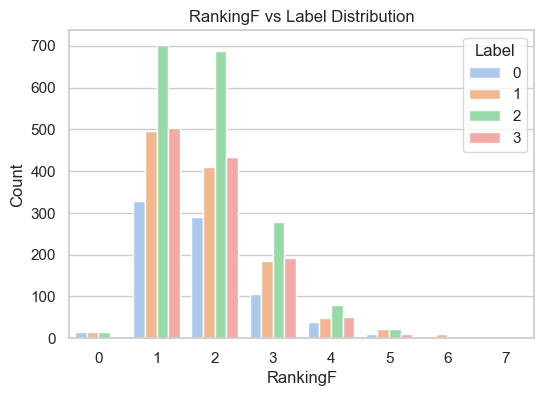

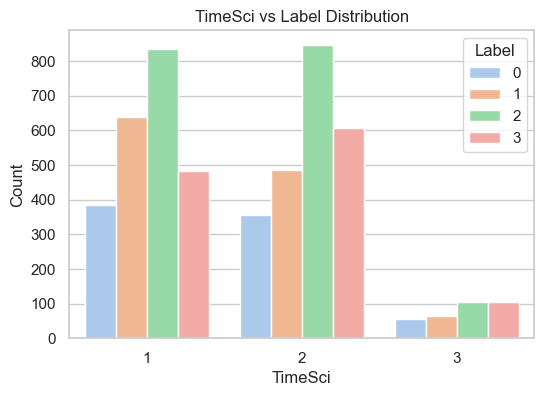

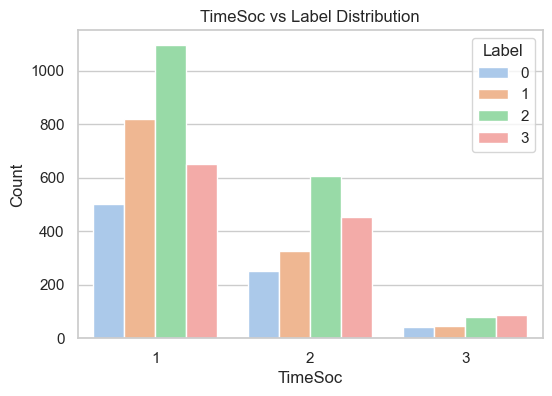

In [36]:
categorical_columns = ['RankingF', 'TimeSci', 'TimeSoc']

# 2. Categorical Features vs Points
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='Points', data=df, palette='coolwarm')
    plt.title(f"{col} vs Points")
    plt.xlabel(col)
    plt.ylabel("Points")
    plt.show()

# 3. Categorical Relationships with Label
for col in categorical_columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='label', data=df, palette='pastel')
    plt.title(f"{col} vs Label Distribution")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Label")
    plt.show()


# Analysis of Future Jobs: Grouping Future Job

**Define categories like:**
STEM: Science, Technology, Engineering, Mathematics-related roles.

Health: Medical and healthcare-related roles.

Education: Teaching and academic roles.

Business: Business, management, and finance-related roles.

Arts: Creative and performing arts-related roles.

Other: Miscellaneous or undefined roles.

Create a new column, FutureJobGroup, based on the mapping.

C:\Users\hient\AppData\Local\Temp\ipykernel_19932\706206664.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_job_group_counts.index, y=future_job_group_counts.values, palette='tab10')


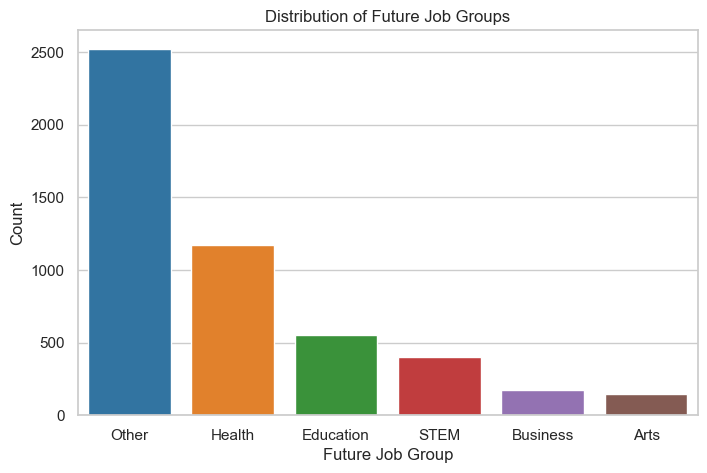

In [37]:
# Define a mapping for FutureJob categories
def group_future_job(job):
    if any(word in job.lower() for word in ['engineer', 'scientist', 'developer', 'programmer']):
        return 'STEM'
    elif any(word in job.lower() for word in ['doctor', 'nurse', 'dentist', 'pharmacist']):
        return 'Health'
    elif any(word in job.lower() for word in ['teacher', 'professor', 'educator']):
        return 'Education'
    elif any(word in job.lower() for word in ['business', 'manager', 'accountant', 'finance']):
        return 'Business'
    elif any(word in job.lower() for word in ['artist', 'writer', 'actor', 'musician']):
        return 'Arts'
    else:
        return 'Other'

# Create a new column for grouped future job categories
df['FutureJobGroup'] = df['FutureJob'].apply(group_future_job)

# Check the distribution of the new grouping
future_job_group_counts = df['FutureJobGroup'].value_counts()

# Visualize the distribution of FutureJobGroup
plt.figure(figsize=(8, 5))
sns.barplot(x=future_job_group_counts.index, y=future_job_group_counts.values, palette='tab10')
plt.title("Distribution of Future Job Groups")
plt.xlabel("Future Job Group")
plt.ylabel("Count")
plt.show()


C:\Users\hient\AppData\Local\Temp\ipykernel_19932\2655747374.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='FutureJobGroup', x='Points', data=df, palette='Set3')


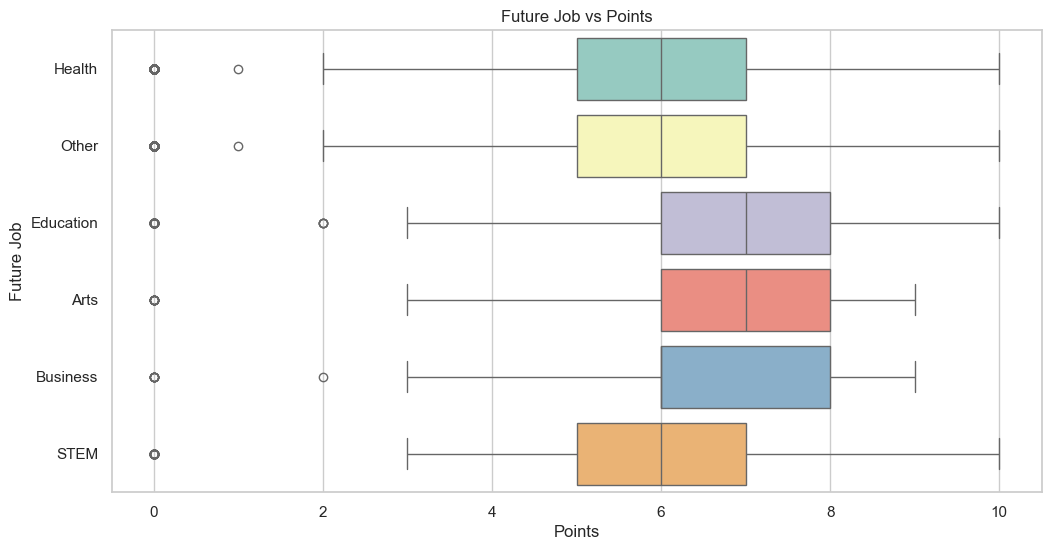

In [38]:
# 2. FutureJob vs Points
plt.figure(figsize=(12, 6))
sns.boxplot(y='FutureJobGroup', x='Points', data=df, palette='Set3')
plt.title("Future Job vs Points")
plt.xlabel("Points")
plt.ylabel("Future Job")
plt.show()

<Figure size 1200x600 with 0 Axes>

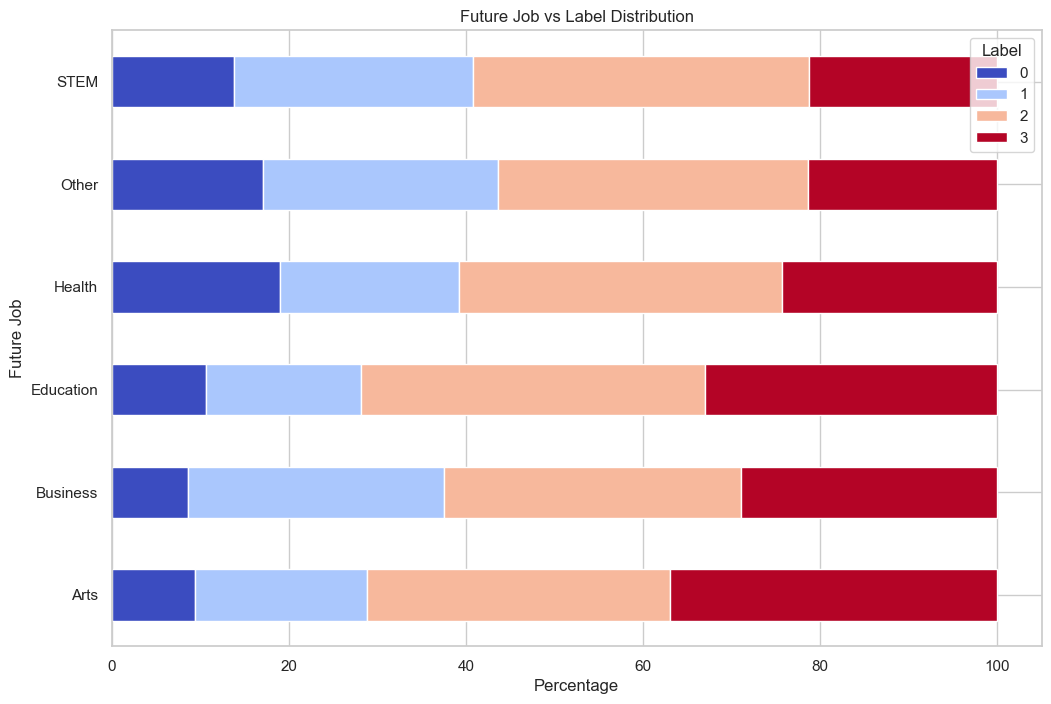

In [39]:
# 3. FutureJob vs Label Distribution
plt.figure(figsize=(12, 6))
future_job_label = pd.crosstab(df['FutureJobGroup'], df['label'], normalize='index') * 100
future_job_label.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='coolwarm')
plt.title("Future Job vs Label Distribution")
plt.xlabel("Percentage")
plt.ylabel("Future Job")
plt.legend(title="Label")
plt.show()

#### Variable transformation

In [40]:
df.head(5)

School  Grade     Sex  RankingF  NumberofChi Readbook  \
0       2      8  Female         3            4      yes   
1       3      9  Female         0            0      yes   
2       3      9  Female         1            2      yes   
3       3      9  Female         1            2      yes   
4       3      9  Female         2            3      yes   

                               Topic       FutureJob       CareerFat CarFatGr  \
0                  History/geography          Doctor          Farmer    Labor   
1  Natural science/chemistry/biology         Painter  Police officer    Labor   
2                         Literature          Worker          Farmer    Labor   
3  Natural science/chemistry/biology  Public servant          Worker    Labor   
4  Natural science/chemistry/biology         Athlete          Farmer    Labor   

   AgeFat   EduFat CareerMot       CarMotGr  AgeMot   EduMot EcoStt  \
0      48  UnderHi    Worker          Labor      40  UnderHi    med   
1      45      Uni   Teacher  Intellectuals      35      Uni   rich   
2      45       Hi    Farmer          Labor      35       Hi    med   
3      41       Hi    Worker          Labor      40       Hi    med   
4      38  UnderHi    Farmer          Labor      36  UnderHi    med   

  KnowledgeInc Buybook                           Hobby  TimeSci  TimeSoc  \
0           no     yes                   Reading books        2        2   
1           no     yes  Watching TV/listening to music        2        1   
2           no     yes               Housework/farming        2        1   
3           no     yes  Watching TV/listening to music        1        1   
4           no     yes  Watching TV/listening to music        1        1   

  Readstory         Typebook                Reason  Source  \
0        no  Popular science  Personal preferences     buy   
1       yes             Arts  Personal preferences     buy   
2        no            Novel  Personal preferences     buy   
3        no  Popular science  Personal preferences     buy   
4        no            Novel  Personal preferences  borrow   

                                         PrioAct  \
0                    Sharing with friends/family   
1             Applying the content to daily life   
2                    Sharing with friends/family   
3  Reflecting and relating to personal knowledge   
4                    Sharing with friends/family   

                                    AftAct EncourAct  \
0  Finding more books on the related issue       yes   
1    Finding more books on the exact issue       yes   
2    Finding more books on the exact issue       yes   
3    Finding more books on the exact issue       yes   
4  Finding more books on the related issue       yes   

                             MostlikedAct                 Bookcase  Points  \
0                Storytelling competition             No bookshelf       7   
1  Illustrating books’ content by drawing             Lack of book       0   
2                Storytelling competition  Diverse and interesting       6   
3                         Book exhibition             No bookshelf       8   
4  Illustrating books’ content by drawing             No bookshelf       9   

   label  Number_of_typebook FutureJobGroup  
0      2                   1         Health  
1      0                   1          Other  
2      2                   1          Other  
3      3                   1          Other  
4      3                   1          Other

In [41]:
def map_future_job(job):
  if len(df[df['CareerFat'] == job]) > 0:
    return df[df['CareerFat'] == job]['CarFatGr'].values[0]
  if len(df[df['CareerMot'] == job]) > 0:
    return df[df['CareerMot'] == job]['CarMotGr'].values[0]
  return 'other'

df['JobCat'] = df['FutureJob'].apply(map_future_job)

In [42]:
# drop 2 columns:  Estimated Income and Typebook_Other
df.drop(['FutureJob', 'CareerFat', 'CareerMot'], axis=1, inplace=True)

In [43]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode all categorical columns in the DataFrame
df = df.apply(lambda col: label_encoder.fit_transform(col) if col.dtypes == 'object' else col)

# Print the first 10 rows after encoding
print(df.head(10))

   School  Grade  Sex  RankingF  NumberofChi  Readbook  Topic  CarFatGr  \
0       2      8    0         3            4         1      1         1   
1       3      9    0         0            0         1      5         1   
2       3      9    0         1            2         1      3         1   
3       3      9    0         1            2         1      5         1   
4       3      9    0         2            3         1      5         1   
5       3      9    1         1            2         1      1         1   
6       3      9    0         2            2         1      5         1   
7       3      9    0         1            2         1      3         1   
8       3      9    0         4            4         1      3         1   
9       2      8    0         1            2         1      5         1   

   AgeFat  EduFat  CarMotGr  AgeMot  EduMot  EcoStt  KnowledgeInc  Buybook  \
0      48       2         1      40       2       0             0        1   
1      45       3 

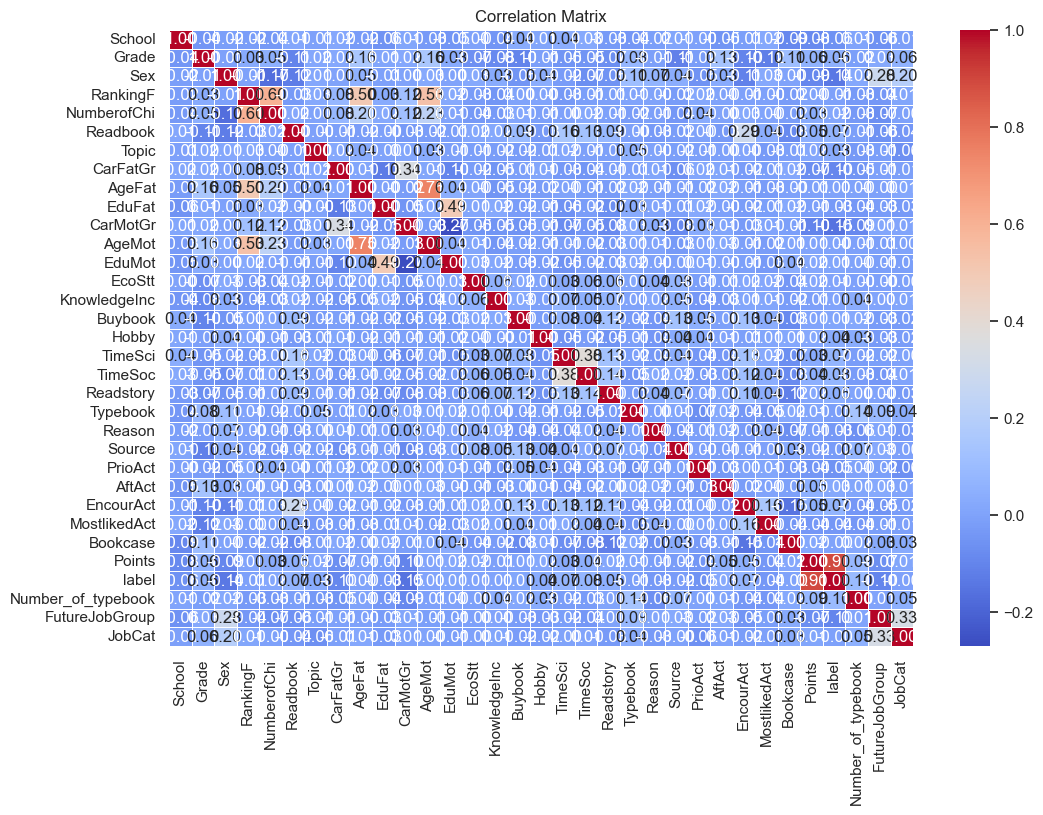

In [44]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Training model

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [46]:
!pip install catboost

     -------------------------------------- 101.8/101.8 MB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 19.1/19.1 MB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 47.1/47.1 KB 2.5 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\hient\education\Scripts\python.exe -m pip install --upgrade pip' command.


In [48]:
!pip install lightgbm

     ---------------------------------------- 1.4/1.4 MB 2.7 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\hient\education\Scripts\python.exe -m pip install --upgrade pip' command.


In [50]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

In [51]:
# Split the independent variables (X) and the dependent variable (y) (Use the 'label' column instead of 'Points')
X = df.drop(columns=['label'])  # Independent variables
y = df['label']  # Dependent variable

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
X_test

School  Grade  Sex  RankingF  NumberofChi  Readbook  Topic  CarFatGr  \
3138       6      9    0         2            2         1      5         1   
1964       4      9    1         2            2         1      2         1   
1344       7      9    0         2            2         1      5         1   
2984       8      6    0         3            3         1      1         1   
4910       7      9    1         1            3         0      3         1   
...      ...    ...  ...       ...          ...       ...    ...       ...   
422        2      9    1         1            3         1      4         1   
95         2      9    1         3            4         0      3         1   
4869       5      6    1         1            3         1      4         1   
4906       7      9    1         1            2         0      3         1   
1924       4      6    1         2            2         1      2         1   

      AgeFat  EduFat  CarMotGr  AgeMot  EduMot  EcoStt  KnowledgeInc  Buybook  \
3138      44       0         1      41       2       0             0        1   
1964      46       2         1      44       2       0             0        0   
1344      40       2         1      39       2       0             0        0   
2984      57       0         1      35       2       0             0        1   
4910      45       2         1      45       2       0             0        1   
...      ...     ...       ...     ...     ...     ...           ...      ...   
422       43       2         1      41       2       0             1        1   
95        42       2         1      41       2       0             0        0   
4869      36       0         1      32       0       2             0        1   
4906      41       2         1      39       2       0             0        0   
1924      40       3         0      40       3       0             0        1   

      Hobby  TimeSci  TimeSoc  Readstory  Typebook  Reason  Source  PrioAct  \
3138      5        2        1          0         3       0       1        3   
1964      5        3        3          0         1       0       0        0   
1344      4        1        1          0         5       0       2        1   
2984      0        1        1          0         2       0       0        3   
4910      0        1        1          0         5       0       0        2   
...     ...      ...      ...        ...       ...     ...     ...      ...   
422       0        1        1          0         5       0       0        0   
95        5        1        1          0         0       0       0        3   
4869      4        3        2          0         4       2       0        2   
4906      3        1        1          0         0       0       0        0   
1924      2        1        1          1         3       0       0        1   

      AftAct  EncourAct  MostlikedAct  Bookcase  label  Number_of_typebook  \
3138       1          1             1         1      3                   2   
1964       2          1             0         3      1                   1   
1344       1          1             2         3      3                   1   
2984       2          1             1         2      1                   1   
4910       3          0             0         3      1                   1   
...      ...        ...           ...       ...    ...                 ...   
422        1          0             0         0      2                   1   
95         1          1             2         1      2                   1   
4869       1          1             0         0      2                   1   
4906       1          0             0         3      1                   1   
1924       1          1             1         2      3                   2   

      FutureJobGroup  JobCat  
3138               4       2  
1964               4       2  
1344               2       0  
2984               4       0  
4910               4       1  
...              ...    

In [52]:
scaler = MinMaxScaler()
# Scale data
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
# Transform on X_test
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

Do khi tạo label, các giá trị gần nhau nhưng có thể được phân vào 2 label khác nhau:
ví dụ: 7.9 thì phân vào lớp 1, 8 thì phân vào lớp 2
Điều này dẫn đến khi phân lớp, khả năng dữ liệu thuộc lớp 2 sẽ bị phân loại sai vào lớp 1 và 3 nhiều

Improve: Thêm features và data
Nghiên cứu lại cách đánh label

In [53]:
catboost_model = CatBoostClassifier(
    iterations=100,          # Fixed number of iterations
    loss_function='MultiClass',  # Objective for multiclass classification
    eval_metric='MultiClass',    # Metric for evaluation
    verbose=0                # Suppress training logs
)

# Define the parameter grid for grid search
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5]
}

multi_logloss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring=multi_logloss_scorer,  # Use log loss as the scoring metric
    cv=5,                          # Number of cross-validation folds
    verbose=3,                     # Verbosity level
    n_jobs=-1                      # Use all processors
)

In [54]:
print("XGBoost version:", xgboost.__version__)
print("scikit-learn version:", sklearn.__version__)

XGBoost version: 2.1.3
scikit-learn version: 1.3.1


In [55]:
# Define the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
lgbm_classifier = LGBMClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()

# Define parameter grids for GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multi:softprob'],  # Multiclass classification with probabilities
    'eval_metric': ['mlogloss']
}

lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multiclass'],
    'num_class': [4],
    'metric': ['multi_logloss'],
}

knn_param_grid = {
    'n_neighbors': [4, 6, 8],
    'weights': ['uniform', 'distance']
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with each classifier
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=skf, scoring='f1_micro')
rf_grid_search.fit(X_train, y_train)

xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid, cv=skf, scoring='f1_micro')
xgb_grid_search.fit(X_train, y_train)

lgbm_grid_search = GridSearchCV(lgbm_classifier, lgbm_param_grid, cv=skf, scoring='f1_micro')
lgbm_grid_search.fit(X_train, y_train)

knn_grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=skf, scoring='f1_micro')
knn_grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 205
[LightGBM] [Info] Number of data points in the train set: 3177, number of used features: 32
[LightGBM] [Info] Start training from score -1.817586
[LightGBM] [Info] Start training from score -1.451652
[LightGBM] [Info] Start training from score -1.017045
[LightGBM] [Info] Start training from score -1.419903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 6, 8],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro')

In [56]:
# Print best parameters and best scores for each classifier
print("Random Forest - Best Parameters:", rf_grid_search.best_params_)
print("Random Forest - Best Score:", rf_grid_search.best_score_)

print("XGBoost - Best Parameters:", xgb_grid_search.best_params_)
print("XGBoost - Best Score:", xgb_grid_search.best_score_)

print("LightGBM - Best Parameters:", lgbm_grid_search.best_params_)
print("LightGBM - Best Score:", lgbm_grid_search.best_score_)

print("KNN - Best Parameters:", knn_grid_search.best_params_)
print("KNN - Best Score:", knn_grid_search.best_score_)

Random Forest - Best Parameters: {'max_depth': 10, 'n_estimators': 500}
Random Forest - Best Score: 0.8836861365904664
XGBoost - Best Parameters: {'eval_metric': 'mlogloss', 'max_depth': 6, 'n_estimators': 300, 'objective': 'multi:softprob'}
XGBoost - Best Score: 0.8947619726565594
LightGBM - Best Parameters: {'max_depth': 10, 'metric': 'multi_logloss', 'n_estimators': 100, 'num_class': 4, 'objective': 'multiclass'}
LightGBM - Best Score: 0.8957685788064573
KNN - Best Parameters: {'n_neighbors': 8, 'weights': 'distance'}
KNN - Best Score: 0.4410908860478748


## Evaluation

In [57]:
# Get predictions on the test data
rf_pred = rf_grid_search.predict(X_test)
xgb_pred = xgb_grid_search.predict(X_test)
lgbm_pred = lgbm_grid_search.predict(X_test)
knn_pred = knn_grid_search.predict(X_test)

In [58]:
# save models
joblib.dump(rf_grid_search, "rf_model.pkl")
joblib.dump(xgb_grid_search, "xgb_model.pkl")
joblib.dump(lgbm_grid_search, "lgbm_model.pkl")
joblib.dump(knn_grid_search, "knn_model.pkl")

['knn_model.pkl']

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       0.92      0.59      0.72       259
           2       0.76      0.96      0.85       350
           3       1.00      1.00      1.00       234

    accuracy                           0.88       994
   macro avg       0.92      0.89      0.89       994
weighted avg       0.90      0.88      0.88       994



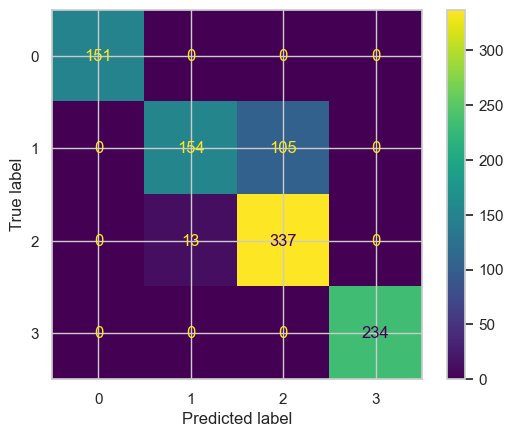

In [59]:
# Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred)

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       0.82      0.80      0.81       259
           2       0.86      0.87      0.86       350
           3       1.00      1.00      1.00       234

    accuracy                           0.90       994
   macro avg       0.92      0.92      0.92       994
weighted avg       0.90      0.90      0.90       994



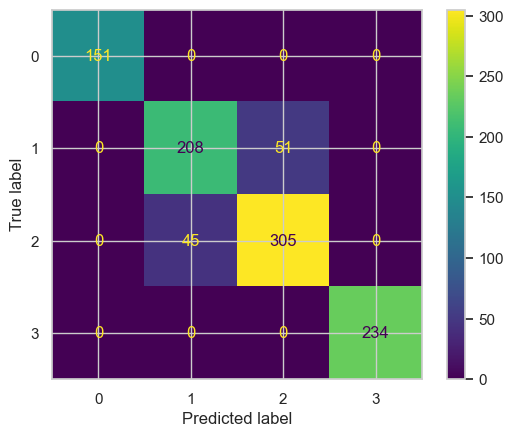

In [60]:
# XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred)

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       0.84      0.83      0.84       259
           2       0.88      0.88      0.88       350
           3       1.00      1.00      1.00       234

    accuracy                           0.92       994
   macro avg       0.93      0.93      0.93       994
weighted avg       0.92      0.92      0.92       994



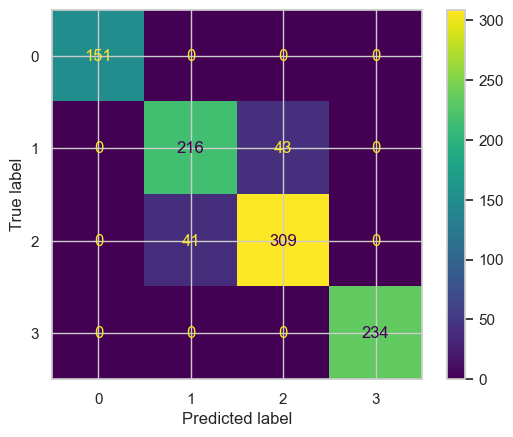

In [61]:
# LightGBM
print("LightGBM Classification Report:")
print(classification_report(y_test, lgbm_pred))
ConfusionMatrixDisplay.from_predictions(y_test, lgbm_pred)

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.44      0.55       151
           1       0.39      0.35      0.37       259
           2       0.43      0.63      0.51       350
           3       0.49      0.34      0.40       234

    accuracy                           0.46       994
   macro avg       0.51      0.44      0.46       994
weighted avg       0.48      0.46      0.45       994



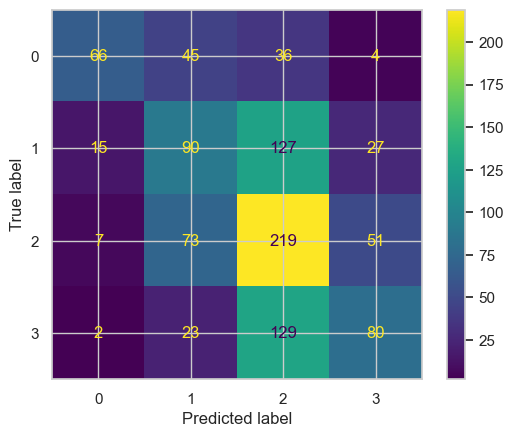

In [62]:
# KNN
print("KNN Classification Report:")
print(classification_report(y_test, knn_pred))
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred)

## Feature Importances

In [63]:
# Feature importances in LightGBM model
# Get feature importances
feature_importances = lgbm_grid_search.best_estimator_.feature_importances_
feature_names = lgbm_grid_search.best_estimator_.feature_name_

feature_importance_table = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the table by feature importance
feature_importance_table = feature_importance_table.sort_values(by='Importance', ascending=False)
feature_importance_table

Feature  Importance
0               School        1524
11              AgeMot        1058
28              Points        1052
8               AgeFat        1035
1                Grade         696
16               Hobby         659
3             RankingF         492
20            Typebook         447
27            Bookcase         420
26        MostlikedAct         418
6                Topic         417
4          NumberofChi         416
24              AftAct         406
23             PrioAct         336
31              JobCat         331
30      FutureJobGroup         267
2                  Sex         263
22              Source         226
17             TimeSci         212
19           Readstory         199
12              EduMot         177
18             TimeSoc         141
9               EduFat         124
21              Reason         100
14        KnowledgeInc          80
13              EcoStt          78
5             Readbook          67
29  Number_of_typebook          58
25           EncourAct          53
15             Buybook          34
10            CarMotGr          29
7             CarFatGr           2

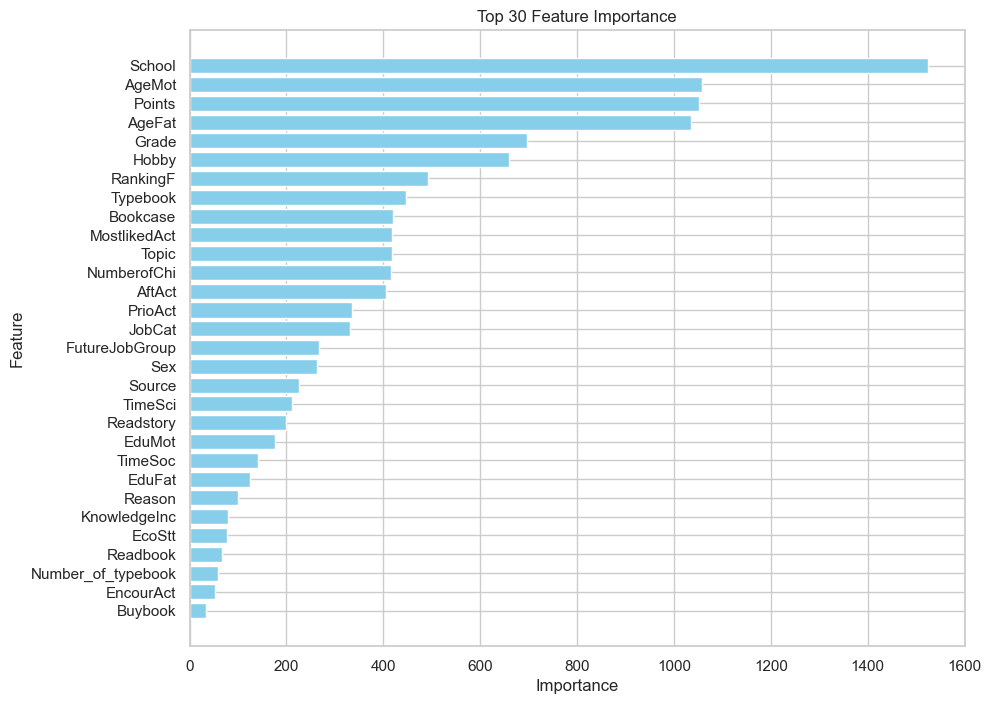

In [64]:
import matplotlib.pyplot as plt

# Assuming 'feature_importance_table' is your DataFrame with columns 'Feature' and 'Importance'
# Sort the DataFrame by 'Importance' in descending order and select the top 15 features
top_30_features = feature_importance_table.sort_values(by='Importance', ascending=False).head(30)

# Plotting the bar chart for the top 15 features
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['Feature'], top_30_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 30 Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Random Forest - Best Parameters: {'max_depth': 10, 'n_estimators': 500}

Random Forest - Best Score: 0.40534036721955546

XGBoost - Best Parameters: {'eval_metric': 'mlogloss', 'max_depth': 6, 'n_estimators': 500, 'objective': 'multi:softprob'}

XGBoost - Best Score: 0.40584572976569555

LightGBM - Best Parameters: {'max_depth': 10, 'metric': 'multi_logloss', 'n_estimators': 300, 'num_class': 4, 'objective': 'multiclass'}

LightGBM - Best Score: 0.4048308857310331

KNN - Best Parameters: {'n_neighbors': 8, 'weights': 'distance'}

KNN - Best Score: 0.33811764333127386

## Model with High features selection

In [65]:
# Subset the data
X_train_selected = X_train[['AgeFat', 'School', 'AgeMot']]

In [66]:
X_test_selected = X_test[['AgeFat', 'School', 'AgeMot']]

In [67]:
# Retrain the model with selected features
model = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=10)
model.fit(X_train_selected, y_train)

# Evaluate on the test set
accuracy = model.score(X_test_selected, y_test)
print(f"Accuracy with Selected Features: {accuracy:.4f}")

Accuracy with Selected Features: 0.3692


In [68]:
# Define the classifiers
rf_classifier = RandomForestClassifier(random_state=42)
xgb_classifier = XGBClassifier(random_state=42)
lgbm_classifier = LGBMClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()

# Define parameter grids for GridSearchCV
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10]
}

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multi:softprob'],  # Multiclass classification with probabilities
    'eval_metric': ['mlogloss']
}

lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 8, 10],
    'objective': ['multiclass'],
    'num_class': [4],
    'metric': ['multi_logloss'],
}

knn_param_grid = {
    'n_neighbors': [4, 6, 8],
    'weights': ['uniform', 'distance']
}

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform Grid Search with each classifier
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=skf, scoring='f1_micro')
rf_grid_search.fit(X_train_selected, y_train)

xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid, cv=skf, scoring='f1_micro')
xgb_grid_search.fit(X_train_selected, y_train)

lgbm_grid_search = GridSearchCV(lgbm_classifier, lgbm_param_grid, cv=skf, scoring='f1_micro')
lgbm_grid_search.fit(X_train_selected, y_train)

knn_grid_search = GridSearchCV(knn_classifier, knn_param_grid, cv=skf, scoring='f1_micro')
knn_grid_search.fit(X_train_selected, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 3177, number of used features: 3
[LightGBM] [Info] Start training from score -1.817586
[LightGBM] [Info] Start training from score -1.451652
[LightGBM] [Info] Start training from score -1.017045
[LightGBM] [Info] Start training from score -1.419903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [4, 6, 8],
                         'weights': ['uniform', 'distance']},
             scoring='f1_micro')

In [69]:
# Print best parameters and best scores for each classifier
print("Random Forest - Best Parameters:", rf_grid_search.best_params_)
print("Random Forest - Best Score:", rf_grid_search.best_score_)

print("XGBoost - Best Parameters:", xgb_grid_search.best_params_)
print("XGBoost - Best Score:", xgb_grid_search.best_score_)

print("LightGBM - Best Parameters:", lgbm_grid_search.best_params_)
print("LightGBM - Best Score:", lgbm_grid_search.best_score_)

print("KNN - Best Parameters:", knn_grid_search.best_params_)
print("KNN - Best Score:", knn_grid_search.best_score_)

Random Forest - Best Parameters: {'max_depth': 6, 'n_estimators': 100}
Random Forest - Best Score: 0.3569982415284444
XGBoost - Best Parameters: {'eval_metric': 'mlogloss', 'max_depth': 6, 'n_estimators': 100, 'objective': 'multi:softprob'}
XGBoost - Best Score: 0.3371097698144892
LightGBM - Best Parameters: {'max_depth': 6, 'metric': 'multi_logloss', 'n_estimators': 100, 'num_class': 4, 'objective': 'multiclass'}
LightGBM - Best Score: 0.34794163775485953
KNN - Best Parameters: {'n_neighbors': 8, 'weights': 'uniform'}
KNN - Best Score: 0.30890547027232546


In [70]:
# Get predictions on the test data
rf_pred = rf_grid_search.predict(X_test_selected)
xgb_pred = xgb_grid_search.predict(X_test_selected)
lgbm_pred = lgbm_grid_search.predict(X_test_selected)
knn_pred = knn_grid_search.predict(X_test_selected)

In [71]:
# Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.01      0.03       151
           1       0.26      0.04      0.07       259
           2       0.36      0.95      0.52       350
           3       0.36      0.03      0.06       234

    accuracy                           0.36       994
   macro avg       0.37      0.26      0.17       994
weighted avg       0.36      0.36      0.22       994



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.21      0.23       151
           1       0.31      0.22      0.26       259
           2       0.38      0.56      0.45       350
           3       0.30      0.23      0.26       234

    accuracy                           0.34       994
   macro avg       0.31      0.30      0.30       994
weighted avg       0.33      0.34      0.32       994



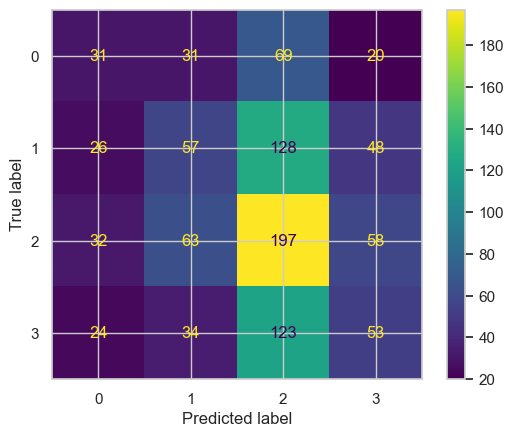

In [72]:
# XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred)

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.18      0.22       151
           1       0.32      0.18      0.23       259
           2       0.36      0.62      0.46       350
           3       0.31      0.20      0.24       234

    accuracy                           0.34       994
   macro avg       0.32      0.30      0.29       994
weighted avg       0.33      0.34      0.31       994



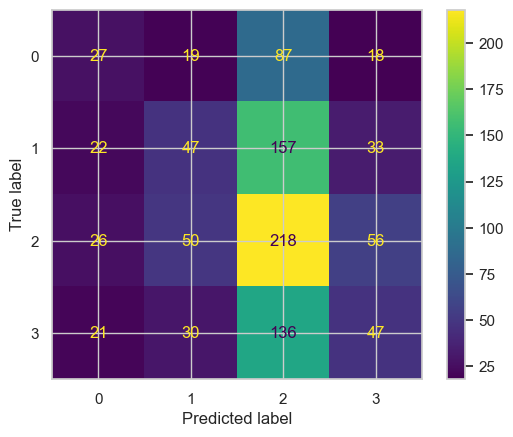

In [73]:
# LightGBM
print("LightGBM Classification Report:")
print(classification_report(y_test, lgbm_pred))
ConfusionMatrixDisplay.from_predictions(y_test, lgbm_pred)

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees in the forest
    'max_depth': [6, 8, 10, 12],       # Maximum depth of each tree
    'max_features': ['auto', 'sqrt']       # Number of features to consider for the best split
}

In [76]:
from sklearn.metrics import mean_squared_error, make_scorer
rf_regressor = RandomForestRegressor(random_state=42)

In [77]:
# Define the scoring function for MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    scoring=mse_scorer,  # Minimize MSE
    cv=5,                # 5-fold cross-validation
    verbose=3,           # Detailed logs during training
    n_jobs=-1            # Use all available processors
)

In [78]:
# Split the independent variables (X) and the dependent variable (y) (Use the 'label' column instead of 'Points')
X = df.drop(columns=['Points'])  # Independent variables
y = df['Points']  # Dependent variable

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Fit the GridSearchCV
grid_search.fit(X_train, y_train)
# Get the best model from GridSearchCV
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error for interpretability

print("Test MSE:", mse)
print("Test RMSE:", rmse)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\hient\education\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hient\education\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hient\education\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\hient\education\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\hient\education\lib\site-packages

Test MSE: 0.8487186017576333
Test RMSE: 0.9212592478546054
